In [1]:
!pip install transformers torch faiss-gpu numpy pandas scikit-learn gensim rouge-score bert-score evaluate rouge


  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5db535888f4fca67ad4863e3e8ac3179747142bca29bdcc845c1833d5d903cff
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import pandas as pd

#Extracting original diseases so that the results from the models can be verified for proper inference
#Then it will be used as the ground truth for calculating the evaluation metrices
test_dataset = pd.read_csv('/kaggle/input/data-preparation-symptom-disease-classification/test_primary.csv')
original_diseases = test_dataset['disease'].tolist()

In [3]:
def validate_test_dataset(new_diseases):
    return new_diseases == original_diseases

In [4]:
def is_within_original_labels(predictions):
    # Check if any element in predictions is not in actual_problems
    actual_problems_set = set(original_diseases)
    not_in_actual_problems = [pred for pred in predictions if pred not in actual_problems_set]

    if not_in_actual_problems:
        print("Elements in predictions not found in original_diseases:", not_in_actual_problems)
        return False
    else:
        print("All elements in predictions are found in original_diseases.")
        return True
    

In [5]:
def validate_outputs(actual_problems,predictions):
    return validate_test_dataset(actual_problems) and is_within_original_labels(predictions)

In [6]:
# Creating Index for Post-Processing of outputs using faiss-gpu

import torch
from transformers import AutoTokenizer, AutoModel
import faiss
import numpy as np
import os
import pandas as pd

index_type = "faiss-IndexFlatL2"

tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')


# Function to get BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token
    return embeddings.numpy()

known_labels = original_diseases[:]
# Generate embeddings for known labels
known_label_embeddings = get_bert_embeddings(known_labels)

# Ensure the array is C-contiguous
known_label_embeddings = np.ascontiguousarray(known_label_embeddings)

# Build FAISS index
d = known_label_embeddings.shape[1]  # Dimension of the embeddings

# Change Indexing Type Here
index = faiss.IndexFlatL2(d)
index.add(known_label_embeddings)

# Directory to save the FAISS index
index_directory = f'/kaggle/working/evaluation/{index_type}/indexes'
os.makedirs(index_directory, exist_ok=True)

# File path for the FAISS index
index_file_path = os.path.join(index_directory, f'{index_type}_index.bin')

# Save the FAISS index to a file
faiss.write_index(index, index_file_path)
print(f"FAISS index saved to {index_file_path}")

# Load the FAISS index from the file
loaded_index = faiss.read_index(index_file_path)
print(f"FAISS index loaded from {index_file_path}")

# Function to find most similar known label using FAISS
def find_most_similar_label(prediction, index, known_labels):
    pred_embedding = get_bert_embeddings([prediction])
    D, I = index.search(pred_embedding, 1)  # Search for the nearest neighbor
    most_similar_idx = I[0][0]
    return known_labels[most_similar_idx]

# Function to fix predictions
def fix_predictions(predictions, index, known_labels):
    fixed_predictions = []
    for pred in predictions:
        if pred in known_labels:
            fixed_predictions.append(pred)
        else:
            most_similar_label = find_most_similar_label(pred, index, known_labels)
            fixed_predictions.append(most_similar_label)
    return fixed_predictions

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


FAISS index saved to /kaggle/working/evaluation/faiss-IndexFlatL2/indexes/faiss-IndexFlatL2_index.bin
FAISS index loaded from /kaggle/working/evaluation/faiss-IndexFlatL2/indexes/faiss-IndexFlatL2_index.bin


In [7]:
#dictionary to store evaluation metrics for all models
llms_data = {}

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from rouge import Rouge
from bert_score import score as bert_score
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns  # Add this line for seaborn

def t2t_evaluate(model_name, model_type, csv_file_path):
    
    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Extract actual problems and predictions as lists
    actual_problems = df['output'].tolist()
    predictions = df['prediction'].tolist()
    
    def custom_strip(s, chars):
        chars_set = set(chars)  # Convert list of chars to a set for faster membership checking

        # Strip characters from the start
        while s and s[0] in chars_set:
            s = s[1:]

        # Strip characters from the end
        while s and s[-1] in chars_set:
            s = s[:-1]

        return s

    # Function to segregate and extract health problems
    def extract_health_problems(predictions):
        extracted_problems = []
        followed_instruction_count = 0
        flouted_instruction_count = 0

        for pred in predictions:
            health_problem = pred
            if pred.startswith("Identified Health Problem : "):
                # Followed instruction
                health_problem = pred[len("Identified Health Problem : "):].strip()
                if '\n' not in health_problem or '\n' in health_problem and all(char in [' ', '\n'] for char in health_problem.split('\n')[1:]):
                    # Count as followed instruction
                    followed_instruction_count += 1
                else:
                    # Count as flouted instruction
                    flouted_instruction_count += 1
            elif pred.startswith("Identified Health Problem: "):
                # Followed instruction
                health_problem = pred[len("Identified Health Problem: "):].strip()
                if '\n' not in health_problem or '\n' in health_problem and all(char in [' ', '\n'] for char in health_problem.split('\n')[1:]):
                    # Count as followed instruction
                    followed_instruction_count += 1
                else:
                    # Count as flouted instruction
                    flouted_instruction_count += 1
            else:
                # Flouted instruction
                flouted_instruction_count += 1
            health_problem = health_problem.split('\n')[0].split('#')[0].split('.')[0]

            extracted_problems.append(health_problem)

        return extracted_problems, followed_instruction_count, flouted_instruction_count
    actual_problems, _, _ = extract_health_problems(actual_problems)
    predictions, followed, flouted = extract_health_problems(predictions)
    
    # post-processing
    predictions = fix_predictions(predictions, index, actual_problems)
    
    
    
    
    if (validate_outputs(actual_problems,predictions) == False):
        return "failure"
    
    # Suppress warnings for calculate_rouge_score and calculate_bert_score functions
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        
        def calculate_rouge_score(generated_texts, reference_texts):
            rouge = evaluate.load('rouge')
            results = rouge.compute(predictions=generated_texts, references=reference_texts)
            #rouge_scores = rouge.get_scores(generated_texts, reference_texts)
            #return rouge_scores
            return results

        def calculate_bert_score(generated_texts, reference_texts):
            P, R, F1 = bert_score(generated_texts, reference_texts, lang='en', verbose=False)
            return {
                'precision': P.tolist(),
                'recall': R.tolist(),
                'f1_score': F1.tolist()
            }
    
    # Define a function to calculate classification metrics
    def calculate_classification_metrics(actual, predicted):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            accuracy = accuracy_score(actual, predicted)
            precision = precision_score(actual, predicted, average='weighted', zero_division=0)
            recall = recall_score(actual, predicted, average='weighted', zero_division=0)
            f1 = f1_score(actual, predicted, average='weighted', zero_division=0)
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    # Calculate classification metrics
    classification_metrics = calculate_classification_metrics(actual_problems, predictions)


    # Text-to-Text Metrics
    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_score(predictions, actual_problems)

    # Calculate BERT scores
    bert_scores = calculate_bert_score(predictions, actual_problems)
    


    # Calculate average scores
#     avg_rouge_precision_1 = np.mean([score['rouge-1']['p'] for score in rouge_scores])
#     avg_rouge_recall_1 = np.mean([score['rouge-1']['r'] for score in rouge_scores])
#     avg_rouge_f1_1 = np.mean([score['rouge-1']['f'] for score in rouge_scores])

#     avg_rouge_precision_2 = np.mean([score['rouge-2']['p'] for score in rouge_scores])
#     avg_rouge_recall_2 = np.mean([score['rouge-2']['r'] for score in rouge_scores])
#     avg_rouge_f1_2 = np.mean([score['rouge-2']['f'] for score in rouge_scores])

#     avg_rouge_precision_l = np.mean([score['rouge-l']['p'] for score in rouge_scores])
#     avg_rouge_recall_l = np.mean([score['rouge-l']['r'] for score in rouge_scores])
#     avg_rouge_f1_l = np.mean([score['rouge-l']['f'] for score in rouge_scores])

    avg_bert_precision = np.mean(bert_scores['precision'])
    avg_bert_recall = np.mean(bert_scores['recall'])
    avg_bert_f1 = np.mean(bert_scores['f1_score'])
    
    
    print("\nModel Name : ", model_name)
    print("Model Type : ", model_type)
    print("")
    val = followed*1.0/(followed + flouted)
    print("Valid Instruction Following Predictions Score : ", f'{val:.3f}')
    print("")
    
    print("Classification Metrics:\n")
    print(f"Accuracy: {classification_metrics['accuracy']:.3f}")
    print(f"Precision: {classification_metrics['precision']:.3f}")
    print(f"Recall: {classification_metrics['recall']:.3f}")
    print(f"F1 Score: {classification_metrics['f1_score']:.3f}")
    print("")
    
    
    print("Text to Text Metrics:\n")
    print("ROUGE Scores:")
    print(f"ROUGE-1: {rouge_scores['rouge1']:.3f}")
    print(f"ROUGE-2: {rouge_scores['rouge2']:.3f}")
    print(f"ROUGE-L: {rouge_scores['rougeL']:.3f}")
    print(f"ROUGE-Lsum: {rouge_scores['rougeLsum']:.3f}")
    print("")
    print(f"Average BERT Precision: {avg_bert_precision:.3f}")
    print(f"Average BERT Recall: {avg_bert_recall:.3f}")
    print(f"Average BERT F1 Score: {avg_bert_f1:.3f}")
    
    print("\n\n-------------------------------------------------------------------------------\n")
    
    print("\nmodel-name : ", model_name)
    print("model-type : ",model_type)
    print("")
    val = followed*1.0/(followed + flouted)
    print("valid-instruction-rating : ", f'{val:.3f}')
    print("")
    
    print("classification-metrics:\n")
    print(f"accuracy: {classification_metrics['accuracy']:.3f}")
    print(f"precision: {classification_metrics['precision']:.3f}")
    print(f"recall: {classification_metrics['recall']:.3f}")
    print(f"f1-score: {classification_metrics['f1_score']:.3f}")
    print("")
    
    
    print("text-to-text-metrics:\n")
    print("rouge-scores:")
    print(f"rouge-1: {rouge_scores['rouge1']:.3f}")
    print(f"rouge-2: {rouge_scores['rouge2']:.3f}")
    print(f"rouge-L: {rouge_scores['rougeL']:.3f}")
    print(f"rouge-lsum: {rouge_scores['rougeLsum']:.3f}")
    print("")
    print(f"bert-precision: {avg_bert_precision:.3f}")
    print(f"bert-recall: {avg_bert_recall:.3f}")
    print(f"bert-f1-score: {avg_bert_f1:.3f}")
    
# Initialize the model_name key if it doesn't exist
    if model_name not in llms_data:
        llms_data[model_name] = {}

    # Update the llms_data dictionary with rounded values directly
    llms_data[model_name].update({
        model_type: {
            "valid-instruction-rating": round(val, 3),
            "classification-metrics": {
                "accuracy": round(classification_metrics["accuracy"], 3),
                "precision": round(classification_metrics["precision"], 3),
                "recall": round(classification_metrics["recall"], 3),
                "f1-score": round(classification_metrics["f1_score"], 3)
            },
            "text-to-text-metrics": {
                "rouge-scores": {
                    "rouge-1": round(rouge_scores["rouge1"], 3),
                    "rouge-2": round(rouge_scores["rouge2"], 3),
                    "rouge-L": round(rouge_scores["rougeL"], 3),
                    "rouge-lsum": round(rouge_scores["rougeLsum"], 3)
                },
                "bert-precision": round(avg_bert_precision, 3),
                "bert-recall": round(avg_bert_recall, 3),
                "bert-f1-score": round(avg_bert_f1, 3)
            }
        }
    })

    # Print the updated dictionary
    print("\nUpdated llms_data dictionary:")
    #---------------------------------------------------------------------------------------
    
    #Confusion-Matrix
    # Determine unique labels present in actual_problems and predictions
    unique_labels = np.unique(actual_problems + predictions)

    # Map labels to integer indices
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    mapped_actual_problems = [label_to_index[label] for label in actual_problems]
    mapped_predictions = [label_to_index[label] for label in predictions]

    # Plot confusion matrix
    confusion_mtx = confusion_matrix(mapped_actual_problems, mapped_predictions, labels=np.arange(len(unique_labels)))

    # Plotting the confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(confusion_mtx, annot=False, fmt='d', cmap='Blues')
    plt.xlabel('Original Health Problems')
    plt.ylabel('Predicted Health Problems ')
    plt.title(f'Confusion Matrix for {model_name} ({model_type}) with Post-Processing using {index_type}')
    
    #Saving result .jpg
    image_directory = f'/kaggle/working/evaluation/{index_type}/confusion_matrix/{model_name}'
    os.makedirs(image_directory, exist_ok=True)

    # File path for the FAISS index
    image_file_path = os.path.join(image_directory, f'confusion_matrix_{index_type}_{model_name}_{model_type}.jpg')
    
    # Save confusion matrix as high-resolution JPEG
    plt.savefig(image_file_path, dpi=300)
    
    plt.show()
    
    return "success"


2024-06-15 12:02:33.036315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 12:02:33.036411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 12:02:33.134693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All elements in predictions are found in original_diseases.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  qwen2-7b-instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.997

Classification Metrics:

Accuracy: 0.167
Precision: 0.352
Recall: 0.167
F1 Score: 0.172

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.183
ROUGE-2: 0.086
ROUGE-L: 0.183
ROUGE-Lsum: 0.184

Average BERT Precision: 0.827
Average BERT Recall: 0.855
Average BERT F1 Score: 0.840


-------------------------------------------------------------------------------


model-name :  qwen2-7b-instruct
model-type :  pretrained

valid-instruction-rating :  0.997

classification-metrics:

accuracy: 0.167
precision: 0.352
recall: 0.167
f1-score: 0.172

text-to-text-metrics:

rouge-scores:
rouge-1: 0.183
rouge-2: 0.086
rouge-L: 0.183
rouge-lsum: 0.184

bert-precision: 0.827
bert-recall: 0.855
bert-f1-score: 0.840

Updated llms_data dictionary:


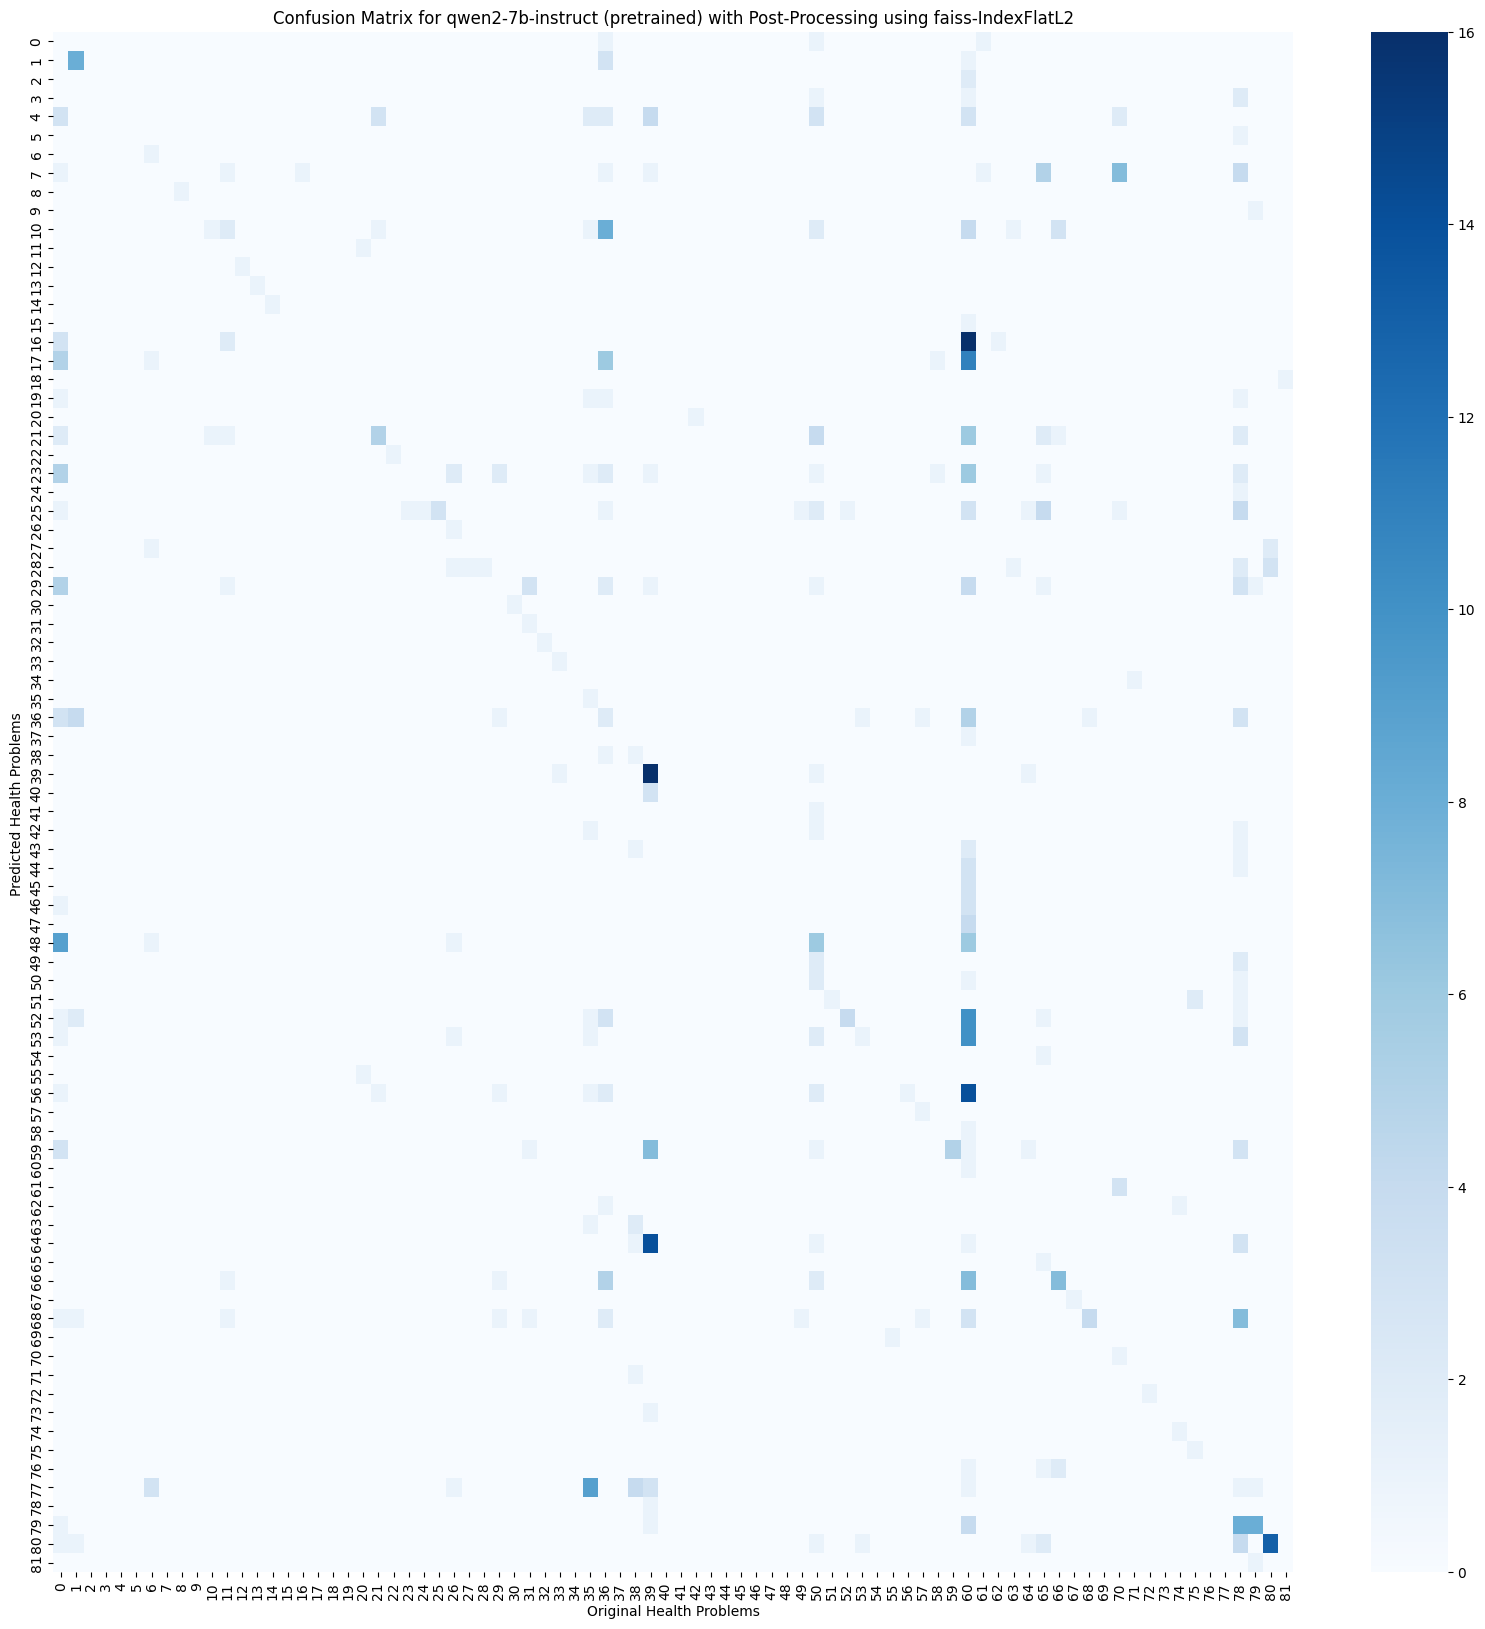

'success'

In [9]:
t2t_evaluate(model_name='Qwen2-7B-Instruct'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-qwen2-7b-instruct-pretrain/results/predictions-Qwen2-7B-Instruct-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  qwen2-7b-instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.998

Classification Metrics:

Accuracy: 0.874
Precision: 0.910
Recall: 0.874
F1 Score: 0.871

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.875
ROUGE-2: 0.422
ROUGE-L: 0.876
ROUGE-Lsum: 0.876

Average BERT Precision: 0.973
Average BERT Recall: 0.979
Average BERT F1 Score: 0.976


-------------------------------------------------------------------------------


model-name :  qwen2-7b-instruct
model-type :  fine-tuned

valid-instruction-rating :  0.998

classification-metrics:

accuracy: 0.874
precision: 0.910
recall: 0.874
f1-score: 0.871

text-to-text-metrics:

rouge-scores:
rouge-1: 0.875
rouge-2: 0.422
rouge-L: 0.876
rouge-lsum: 0.876

bert-precision: 0.973
bert-recall: 0.979
bert-f1-score: 0.976

Updated llms_data dictionary:


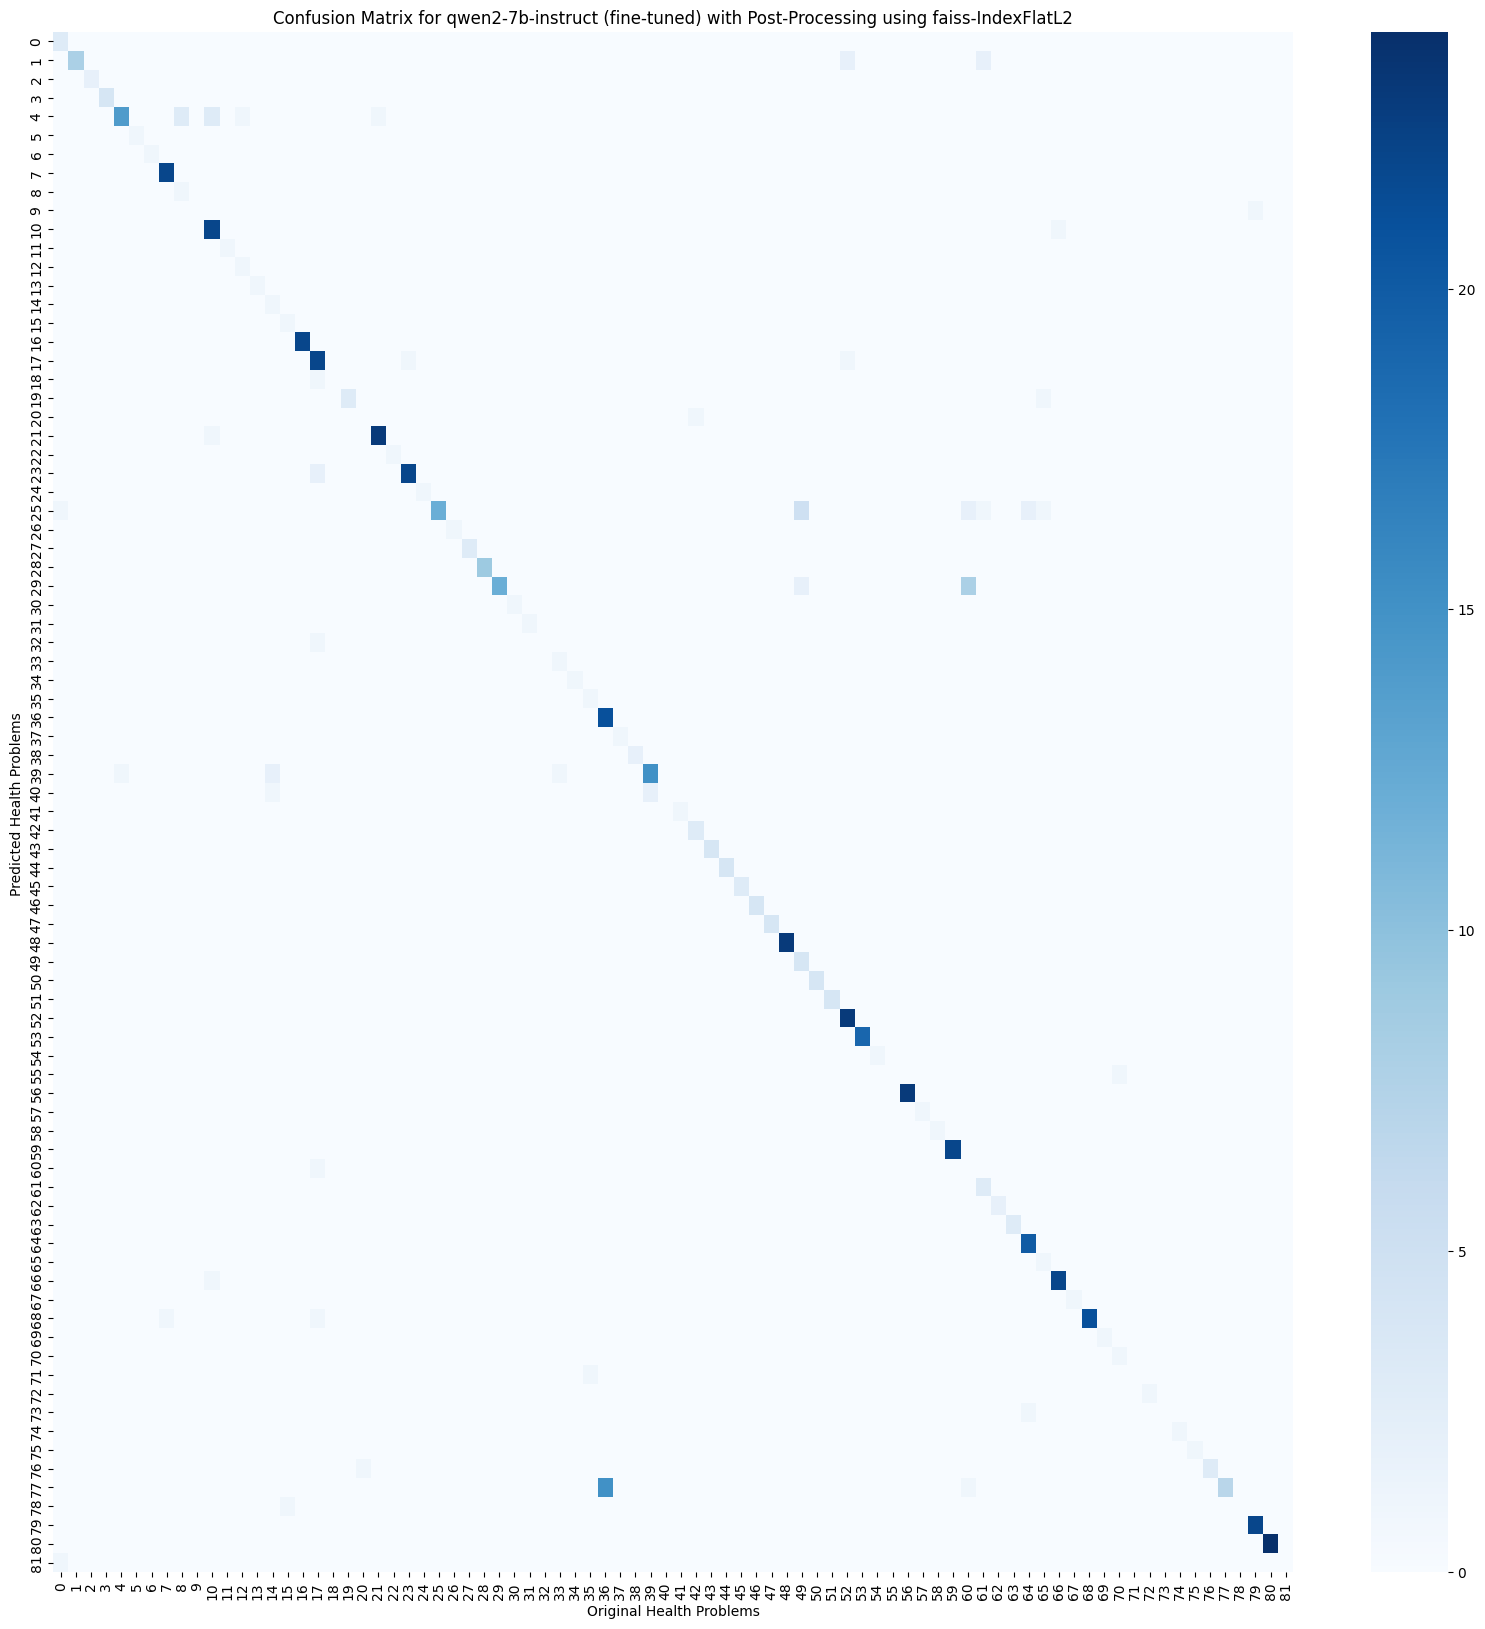

'success'

In [10]:
t2t_evaluate(model_name='Qwen2-7B-Instruct'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-qwen2-7b-instruct-fine-tune/results/predictions-Qwen2-7B-Instruct-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  gemma-7b-instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.134

Classification Metrics:

Accuracy: 0.154
Precision: 0.216
Recall: 0.154
F1 Score: 0.152

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.161
ROUGE-2: 0.097
ROUGE-L: 0.161
ROUGE-Lsum: 0.161

Average BERT Precision: 0.841
Average BERT Recall: 0.838
Average BERT F1 Score: 0.838


-------------------------------------------------------------------------------


model-name :  gemma-7b-instruct
model-type :  pretrained

valid-instruction-rating :  0.134

classification-metrics:

accuracy: 0.154
precision: 0.216
recall: 0.154
f1-score: 0.152

text-to-text-metrics:

rouge-scores:
rouge-1: 0.161
rouge-2: 0.097
rouge-L: 0.161
rouge-lsum: 0.161

bert-precision: 0.841
bert-recall: 0.838
bert-f1-score: 0.838

Updated llms_data dictionary:


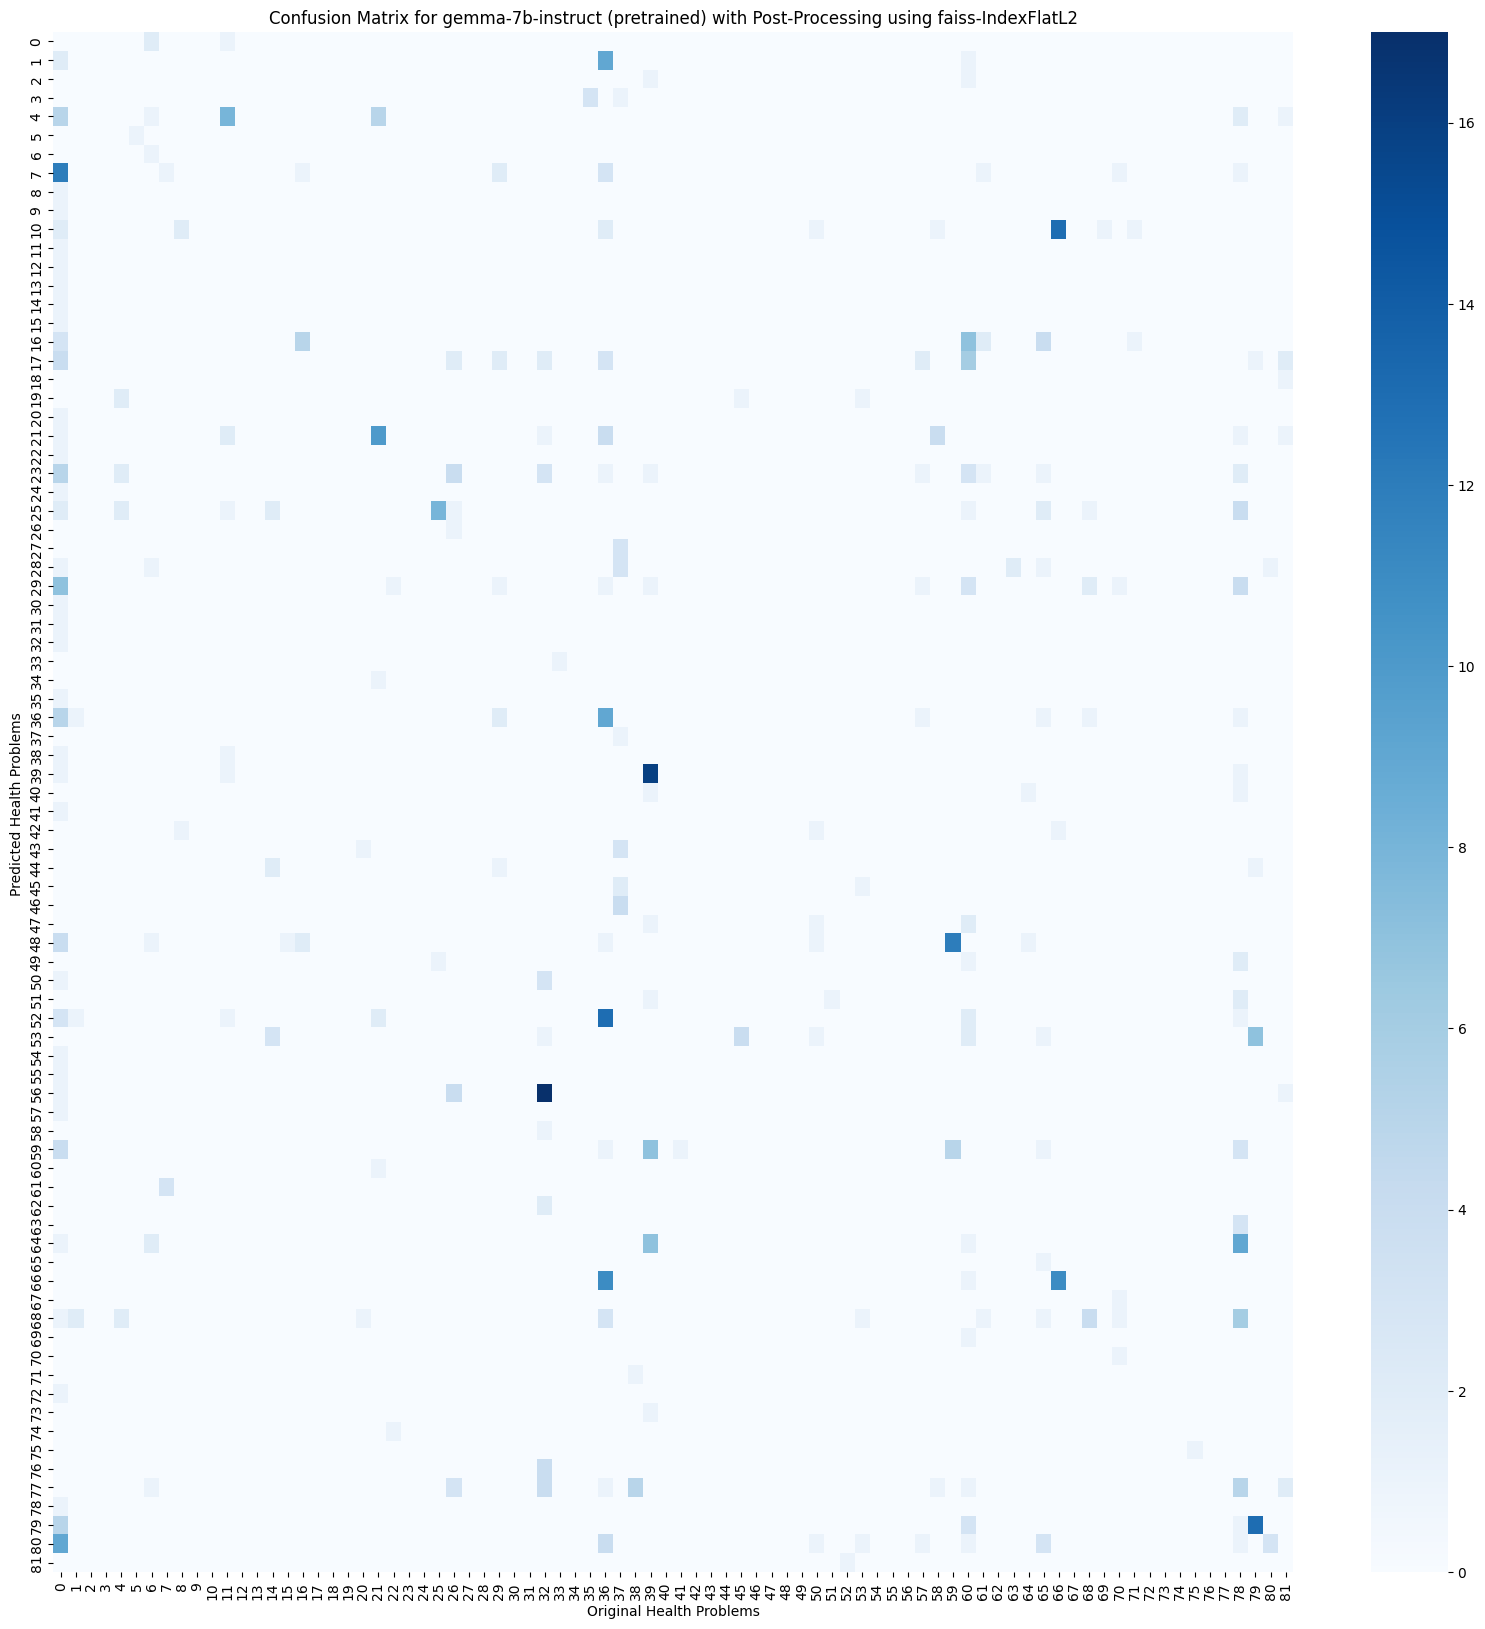

'success'

In [11]:
t2t_evaluate(model_name='Gemma-7B-Instruct'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-gemma-7b-it-pretrain/results/predictions-gemma-7b-it-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  gemma-7b-instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.974

Classification Metrics:

Accuracy: 0.388
Precision: 0.612
Recall: 0.388
F1 Score: 0.407

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.407
ROUGE-2: 0.238
ROUGE-L: 0.405
ROUGE-Lsum: 0.405

Average BERT Precision: 0.874
Average BERT Recall: 0.894
Average BERT F1 Score: 0.883


-------------------------------------------------------------------------------


model-name :  gemma-7b-instruct
model-type :  fine-tuned

valid-instruction-rating :  0.974

classification-metrics:

accuracy: 0.388
precision: 0.612
recall: 0.388
f1-score: 0.407

text-to-text-metrics:

rouge-scores:
rouge-1: 0.407
rouge-2: 0.238
rouge-L: 0.405
rouge-lsum: 0.405

bert-precision: 0.874
bert-recall: 0.894
bert-f1-score: 0.883

Updated llms_data dictionary:


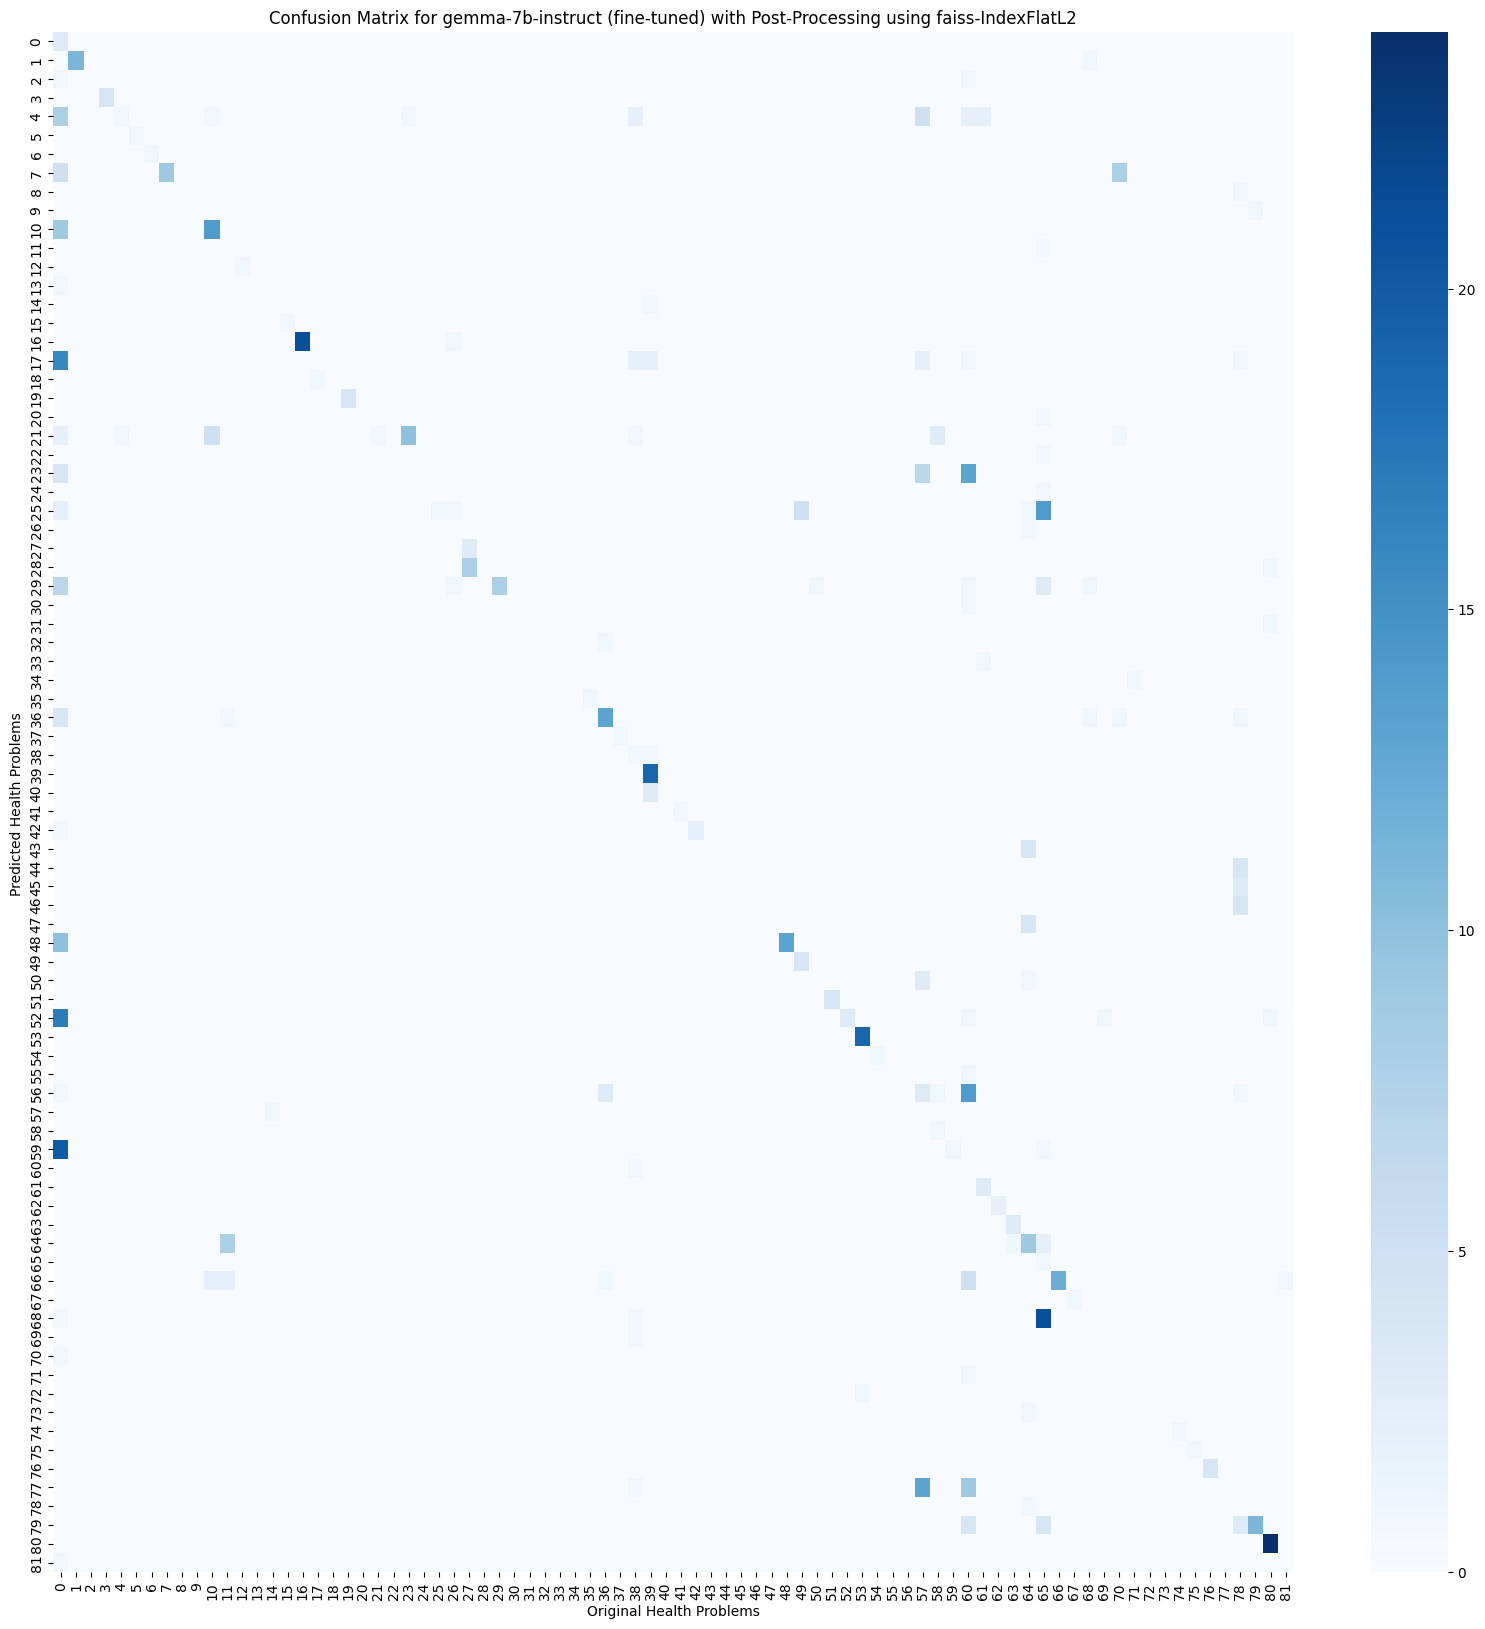

'success'

In [12]:
t2t_evaluate(model_name='Gemma-7B-Instruct'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-gemma-7b-instruct-fine-tune/results/predictions-gemma-7b-instruct-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  mistral-7b-instruct-v0.2
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.982

Classification Metrics:

Accuracy: 0.110
Precision: 0.299
Recall: 0.110
F1 Score: 0.127

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.117
ROUGE-2: 0.065
ROUGE-L: 0.117
ROUGE-Lsum: 0.117

Average BERT Precision: 0.815
Average BERT Recall: 0.840
Average BERT F1 Score: 0.826


-------------------------------------------------------------------------------


model-name :  mistral-7b-instruct-v0.2
model-type :  pretrained

valid-instruction-rating :  0.982

classification-metrics:

accuracy: 0.110
precision: 0.299
recall: 0.110
f1-score: 0.127

text-to-text-metrics:

rouge-scores:
rouge-1: 0.117
rouge-2: 0.065
rouge-L: 0.117
rouge-lsum: 0.117

bert-precision: 0.815
bert-recall: 0.840
bert-f1-score: 0.826

Updated llms_data dictionary:


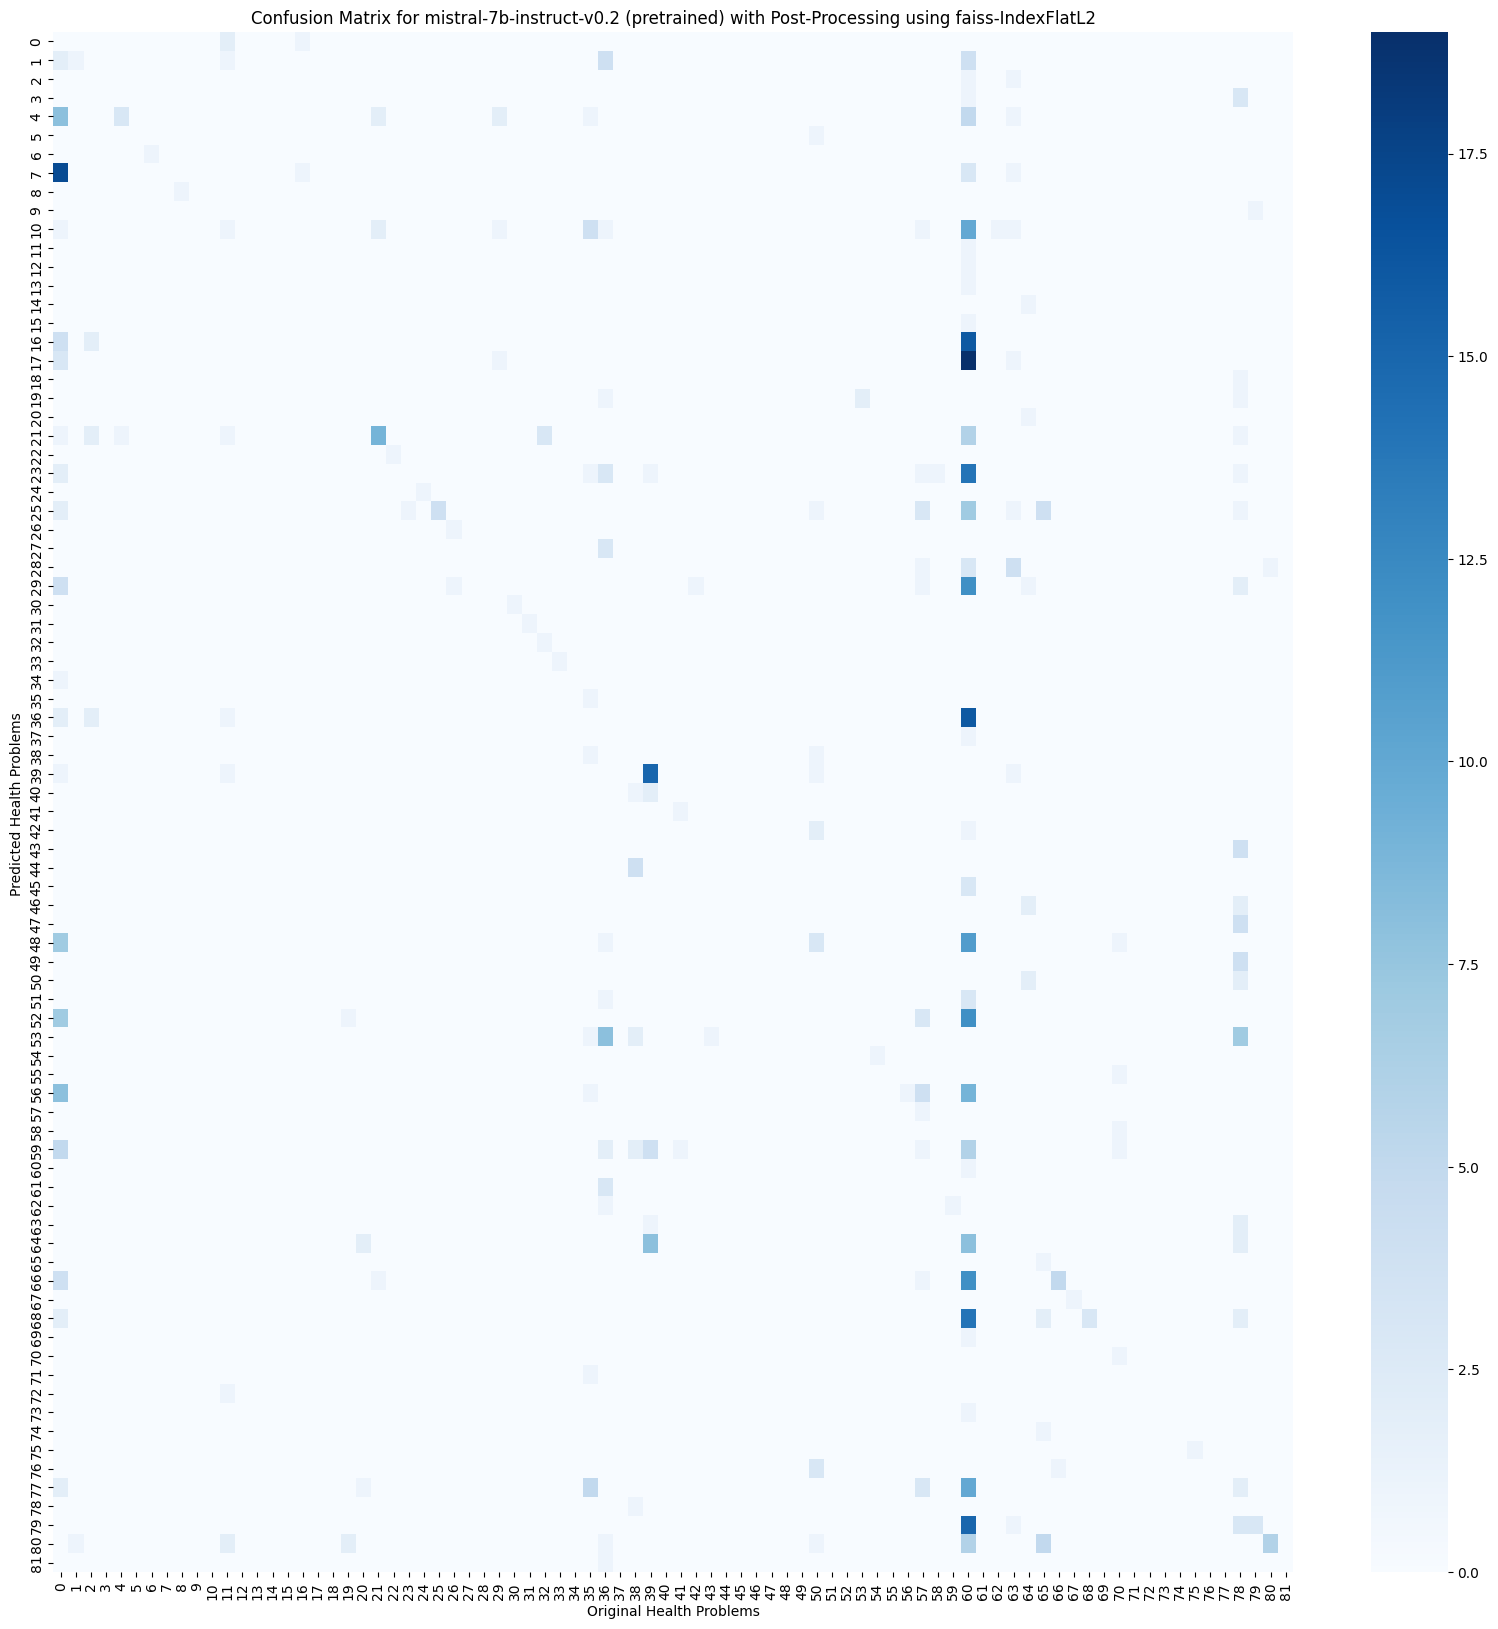

'success'

In [13]:
t2t_evaluate(model_name='Mistral-7B-Instruct-V0.2'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-mistral-7b-it-v2-pretrained/results/predictions-mistral-7b-instruct-v0.2-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  mistral-7b-instruct-v0.2
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.437

Classification Metrics:

Accuracy: 0.699
Precision: 0.773
Recall: 0.699
F1 Score: 0.695

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.719
ROUGE-2: 0.377
ROUGE-L: 0.719
ROUGE-Lsum: 0.719

Average BERT Precision: 0.939
Average BERT Recall: 0.953
Average BERT F1 Score: 0.945


-------------------------------------------------------------------------------


model-name :  mistral-7b-instruct-v0.2
model-type :  fine-tuned

valid-instruction-rating :  0.437

classification-metrics:

accuracy: 0.699
precision: 0.773
recall: 0.699
f1-score: 0.695

text-to-text-metrics:

rouge-scores:
rouge-1: 0.719
rouge-2: 0.377
rouge-L: 0.719
rouge-lsum: 0.719

bert-precision: 0.939
bert-recall: 0.953
bert-f1-score: 0.945

Updated llms_data dictionary:


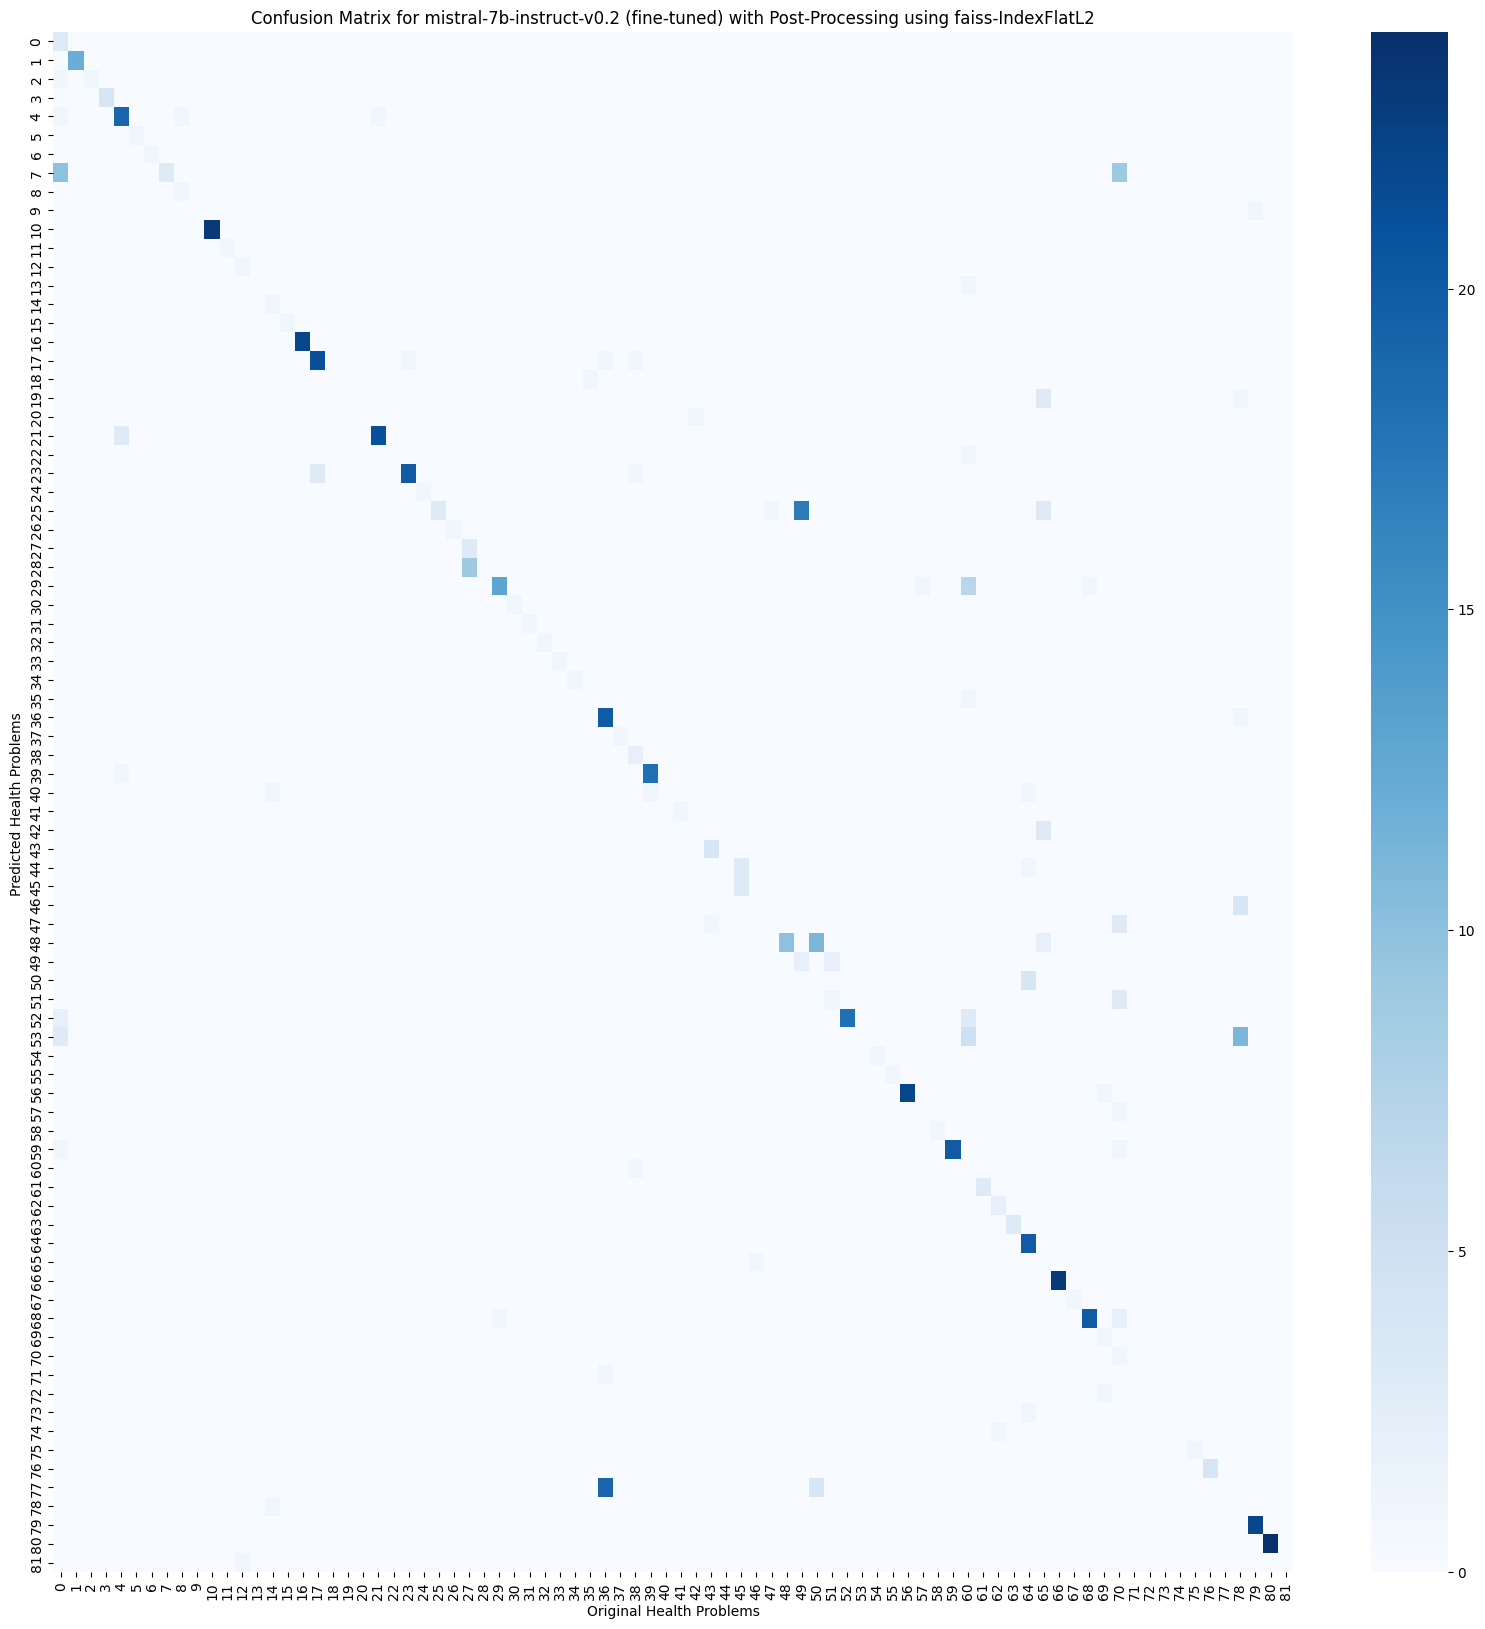

'success'

In [14]:
t2t_evaluate(model_name='Mistral-7B-Instruct-V0.2'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-mistral-7b-it-v2-fine-tuned/results/predictions-mistral-7b-instruct-v0.2-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  phi-3-medium-4k-instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.416

Classification Metrics:

Accuracy: 0.293
Precision: 0.455
Recall: 0.293
F1 Score: 0.284

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.325
ROUGE-2: 0.117
ROUGE-L: 0.324
ROUGE-Lsum: 0.325

Average BERT Precision: 0.862
Average BERT Recall: 0.881
Average BERT F1 Score: 0.870


-------------------------------------------------------------------------------


model-name :  phi-3-medium-4k-instruct
model-type :  pretrained

valid-instruction-rating :  0.416

classification-metrics:

accuracy: 0.293
precision: 0.455
recall: 0.293
f1-score: 0.284

text-to-text-metrics:

rouge-scores:
rouge-1: 0.325
rouge-2: 0.117
rouge-L: 0.324
rouge-lsum: 0.325

bert-precision: 0.862
bert-recall: 0.881
bert-f1-score: 0.870

Updated llms_data dictionary:


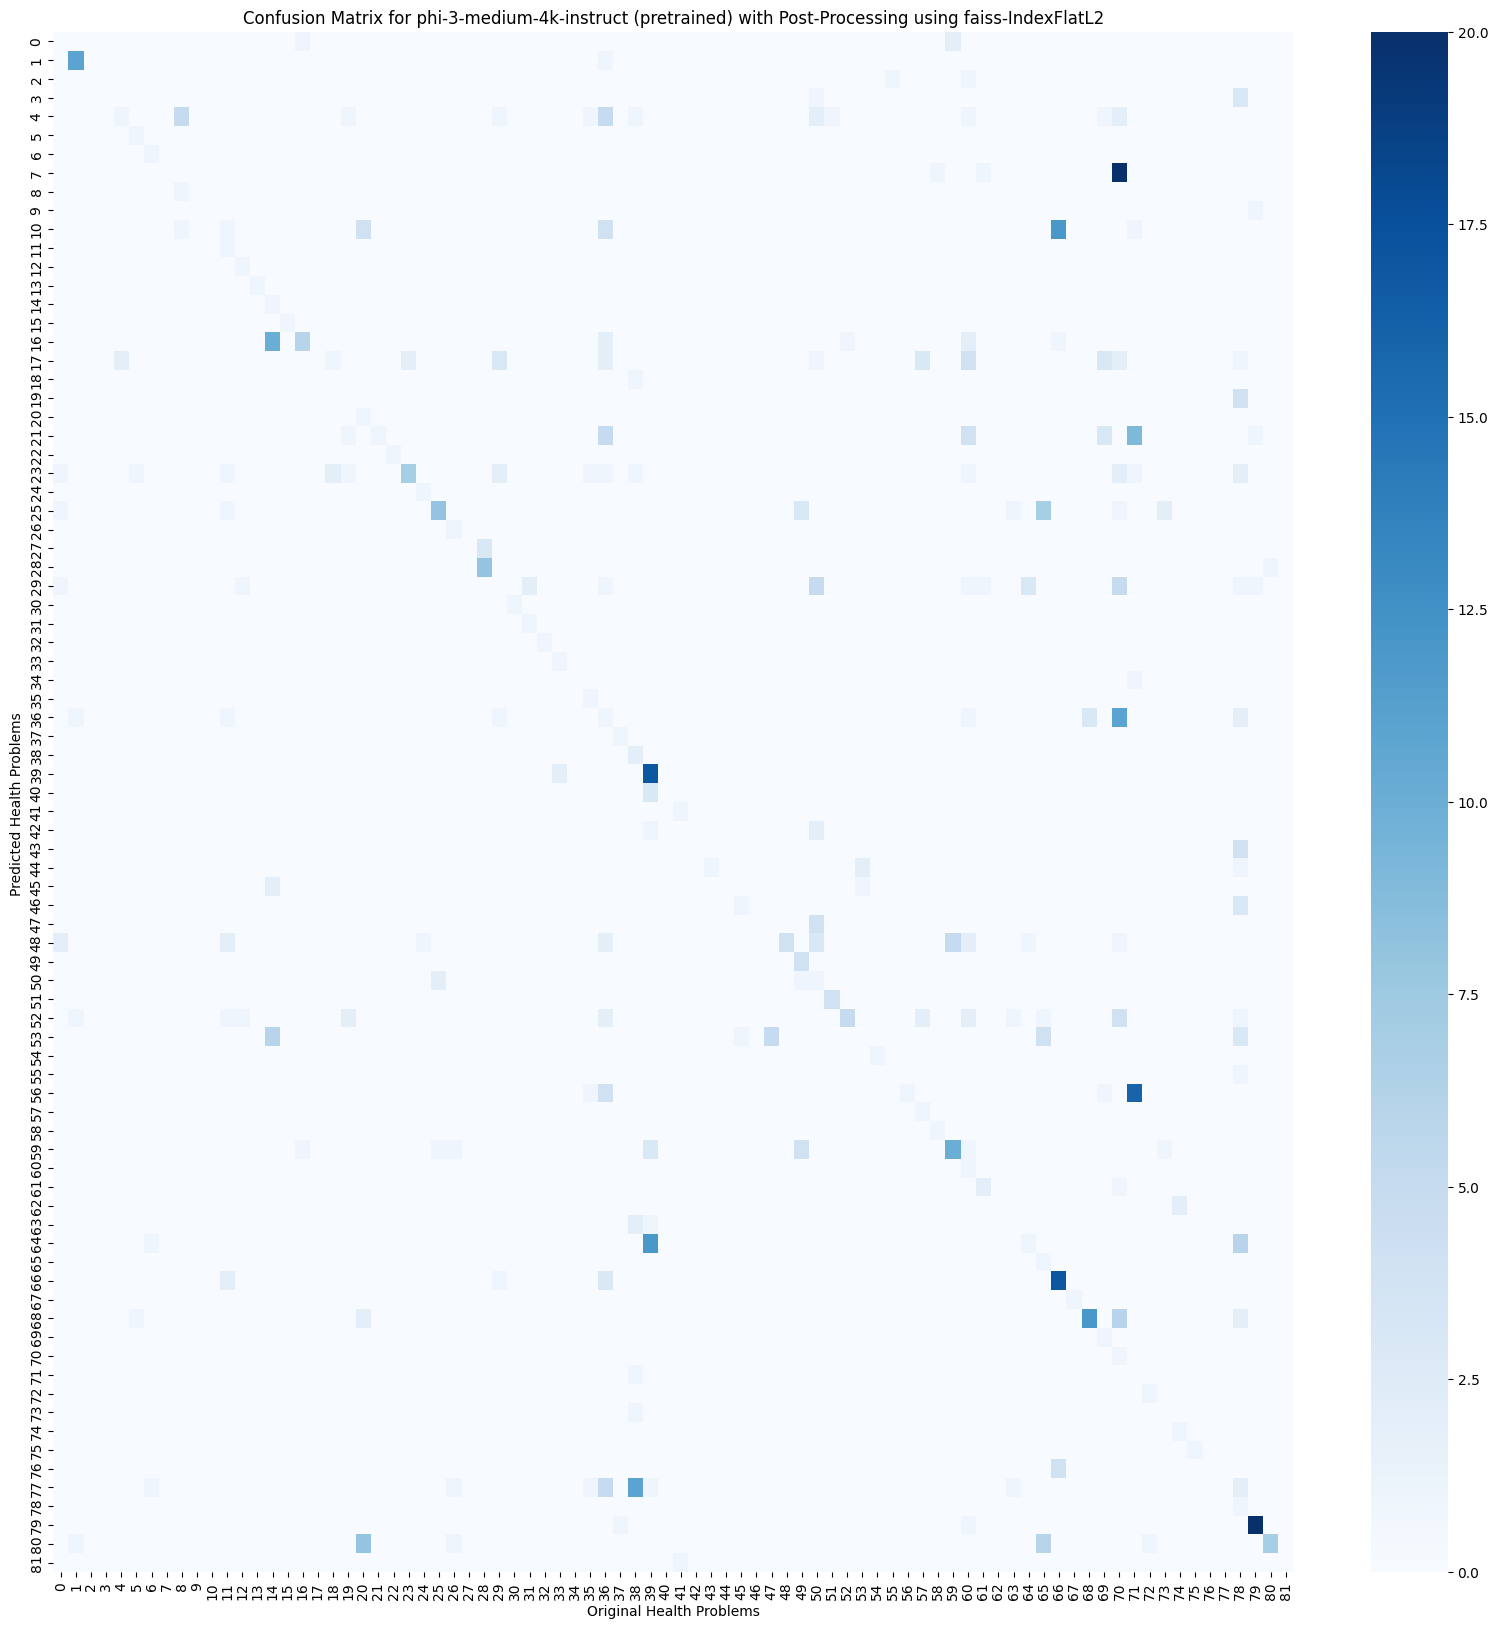

'success'

In [15]:
t2t_evaluate(model_name='Phi-3-Medium-4K-Instruct'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-phi-3-med-4k-it-pretrain/results/predictions-Phi-3-medium-4k-instruct-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  phi-3-medium-4k-instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.968

Classification Metrics:

Accuracy: 0.482
Precision: 0.733
Recall: 0.482
F1 Score: 0.526

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.496
ROUGE-2: 0.299
ROUGE-L: 0.496
ROUGE-Lsum: 0.495

Average BERT Precision: 0.895
Average BERT Recall: 0.917
Average BERT F1 Score: 0.906


-------------------------------------------------------------------------------


model-name :  phi-3-medium-4k-instruct
model-type :  fine-tuned

valid-instruction-rating :  0.968

classification-metrics:

accuracy: 0.482
precision: 0.733
recall: 0.482
f1-score: 0.526

text-to-text-metrics:

rouge-scores:
rouge-1: 0.496
rouge-2: 0.299
rouge-L: 0.496
rouge-lsum: 0.495

bert-precision: 0.895
bert-recall: 0.917
bert-f1-score: 0.906

Updated llms_data dictionary:


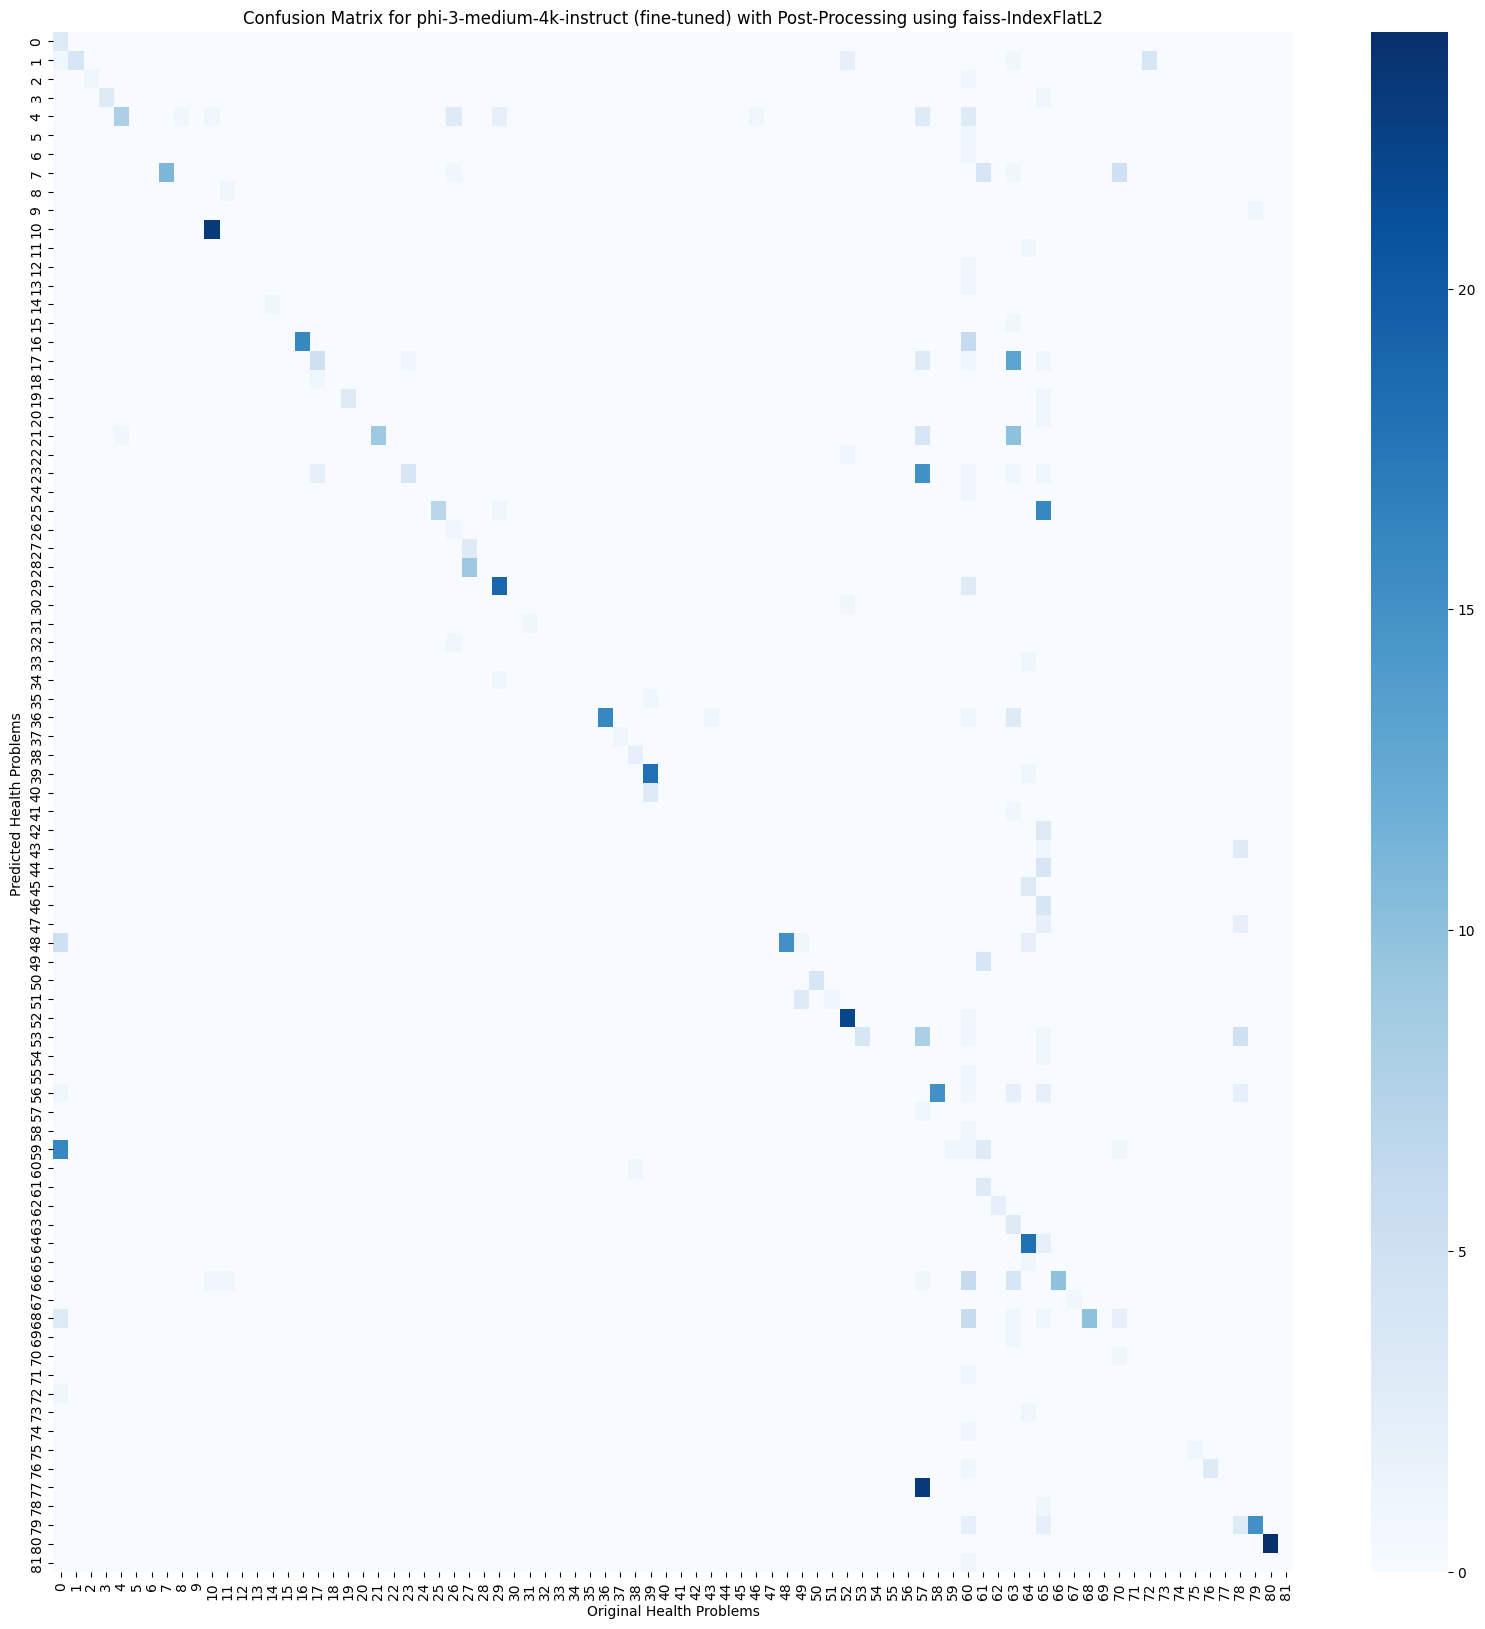

'success'

In [16]:
t2t_evaluate(model_name='Phi-3-Medium-4K-Instruct'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-phi-3-med-4k-it-fine-tuned/results/predictions-Phi-3-medium-4k-instruct-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  medical-llama3-8b
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.013

Classification Metrics:

Accuracy: 0.160
Precision: 0.366
Recall: 0.160
F1 Score: 0.169

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.172
ROUGE-2: 0.073
ROUGE-L: 0.172
ROUGE-Lsum: 0.172

Average BERT Precision: 0.854
Average BERT Recall: 0.845
Average BERT F1 Score: 0.848


-------------------------------------------------------------------------------


model-name :  medical-llama3-8b
model-type :  pretrained

valid-instruction-rating :  0.013

classification-metrics:

accuracy: 0.160
precision: 0.366
recall: 0.160
f1-score: 0.169

text-to-text-metrics:

rouge-scores:
rouge-1: 0.172
rouge-2: 0.073
rouge-L: 0.172
rouge-lsum: 0.172

bert-precision: 0.854
bert-recall: 0.845
bert-f1-score: 0.848

Updated llms_data dictionary:


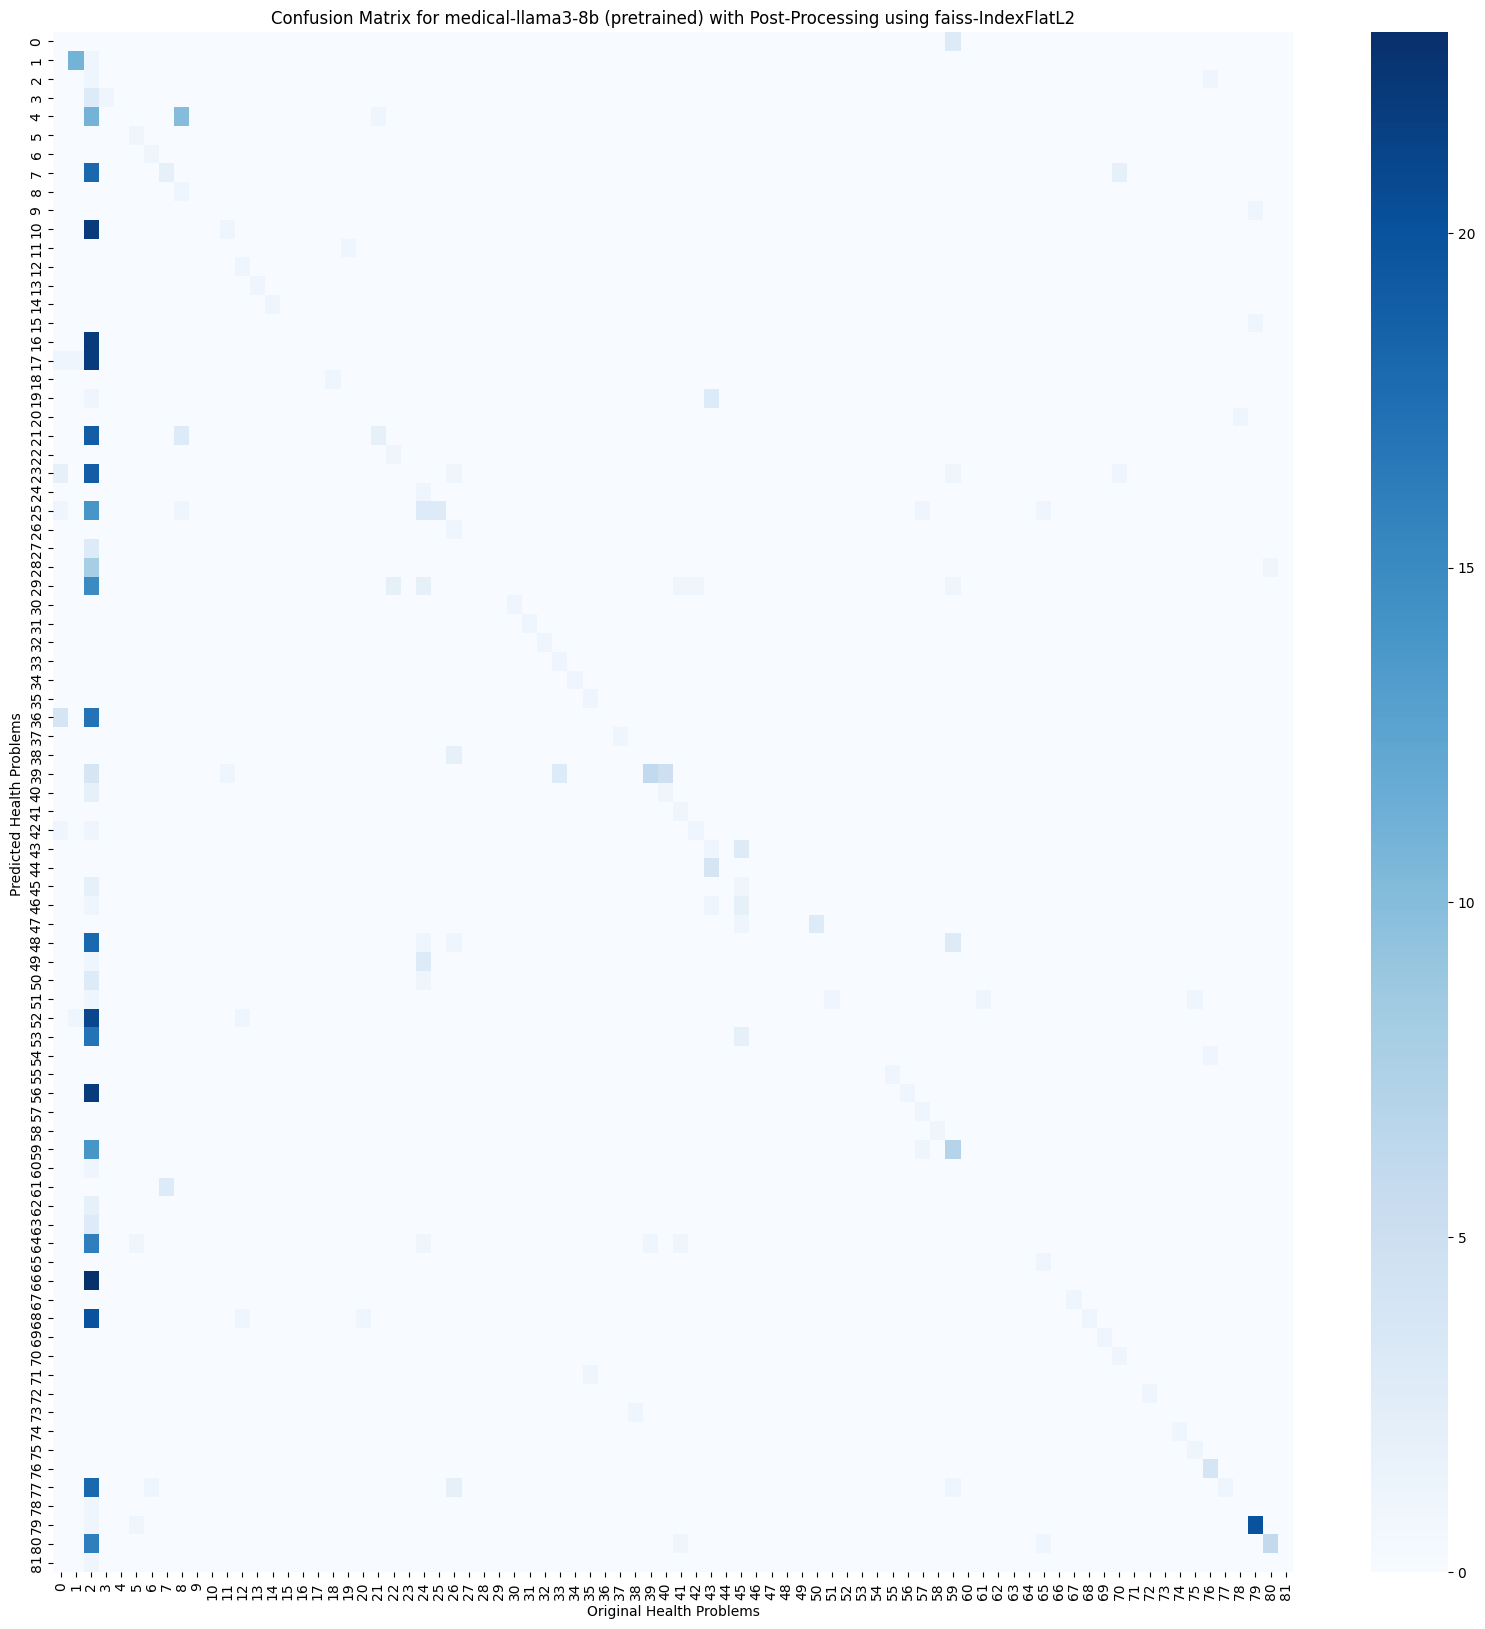

'success'

In [17]:
t2t_evaluate(model_name='Medical-LLaMA3-8B'.lower(),model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-medical-llama3-8b-pretrain/results/predictions-Medical-Llama3-8B-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  medical-llama3-8b
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  0.995

Classification Metrics:

Accuracy: 0.455
Precision: 0.722
Recall: 0.455
F1 Score: 0.477

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.460
ROUGE-2: 0.304
ROUGE-L: 0.460
ROUGE-Lsum: 0.460

Average BERT Precision: 0.889
Average BERT Recall: 0.906
Average BERT F1 Score: 0.897


-------------------------------------------------------------------------------


model-name :  medical-llama3-8b
model-type :  fine-tuned

valid-instruction-rating :  0.995

classification-metrics:

accuracy: 0.455
precision: 0.722
recall: 0.455
f1-score: 0.477

text-to-text-metrics:

rouge-scores:
rouge-1: 0.460
rouge-2: 0.304
rouge-L: 0.460
rouge-lsum: 0.460

bert-precision: 0.889
bert-recall: 0.906
bert-f1-score: 0.897

Updated llms_data dictionary:


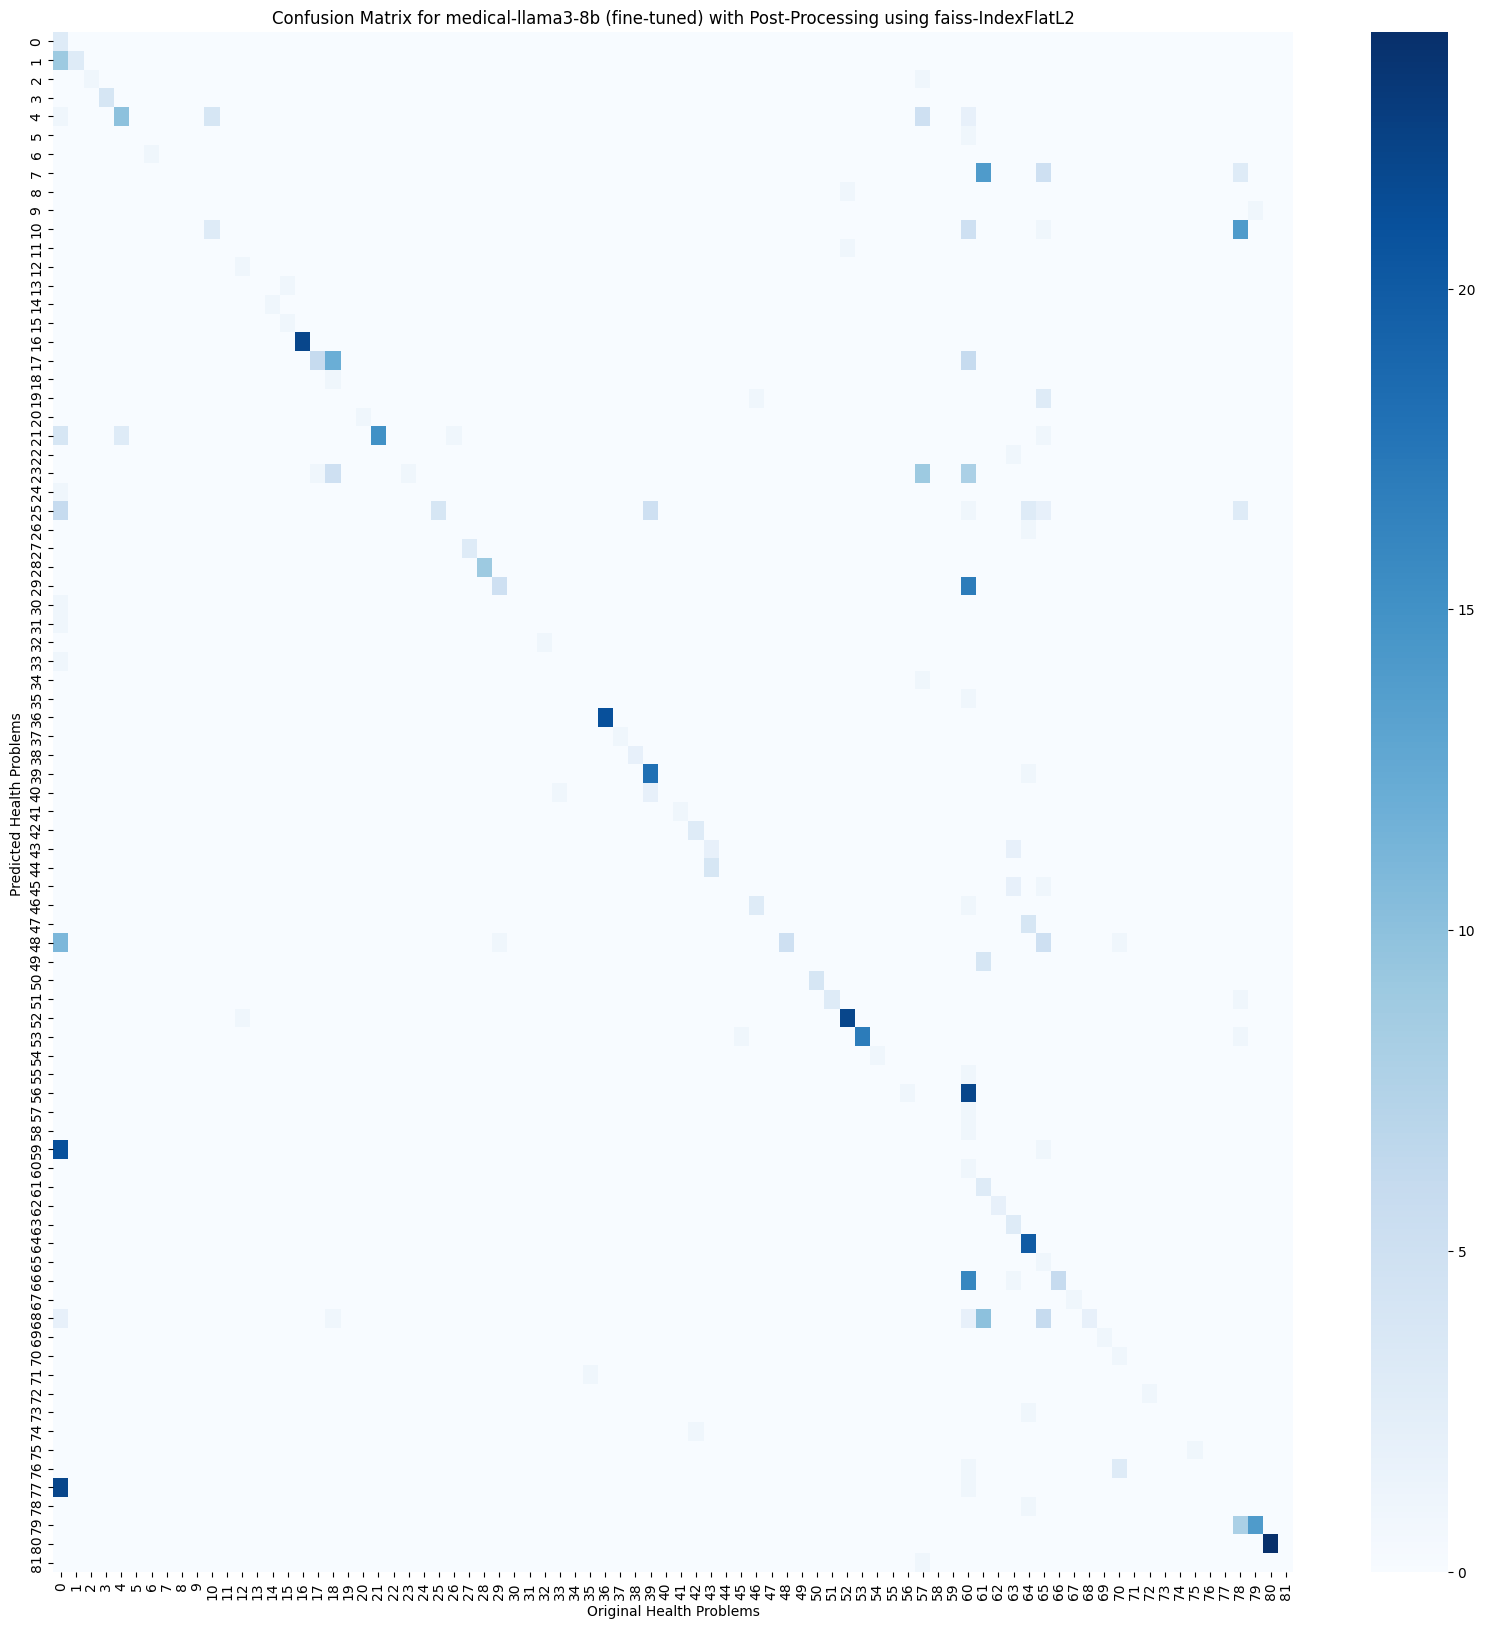

'success'

In [18]:
t2t_evaluate(model_name='Medical-LLaMA3-8B'.lower(),model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-medical-llama3-8b-fine-tune/results/predictions-Medical-Llama3-8B-fine-tuned-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  LLaMA-3-8B-Instruct
Model Type :  pretrained

Valid Instruction Following Predictions Score :  0.751

Classification Metrics:

Accuracy: 0.214
Precision: 0.359
Recall: 0.214
F1 Score: 0.208

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.244
ROUGE-2: 0.091
ROUGE-L: 0.246
ROUGE-Lsum: 0.247

Average BERT Precision: 0.841
Average BERT Recall: 0.870
Average BERT F1 Score: 0.854


-------------------------------------------------------------------------------


model-name :  LLaMA-3-8B-Instruct
model-type :  pretrained

valid-instruction-rating :  0.751

classification-metrics:

accuracy: 0.214
precision: 0.359
recall: 0.214
f1-score: 0.208

text-to-text-metrics:

rouge-scores:
rouge-1: 0.244
rouge-2: 0.091
rouge-L: 0.246
rouge-lsum: 0.247

bert-precision: 0.841
bert-recall: 0.870
bert-f1-score: 0.854

Updated llms_data dictionary:


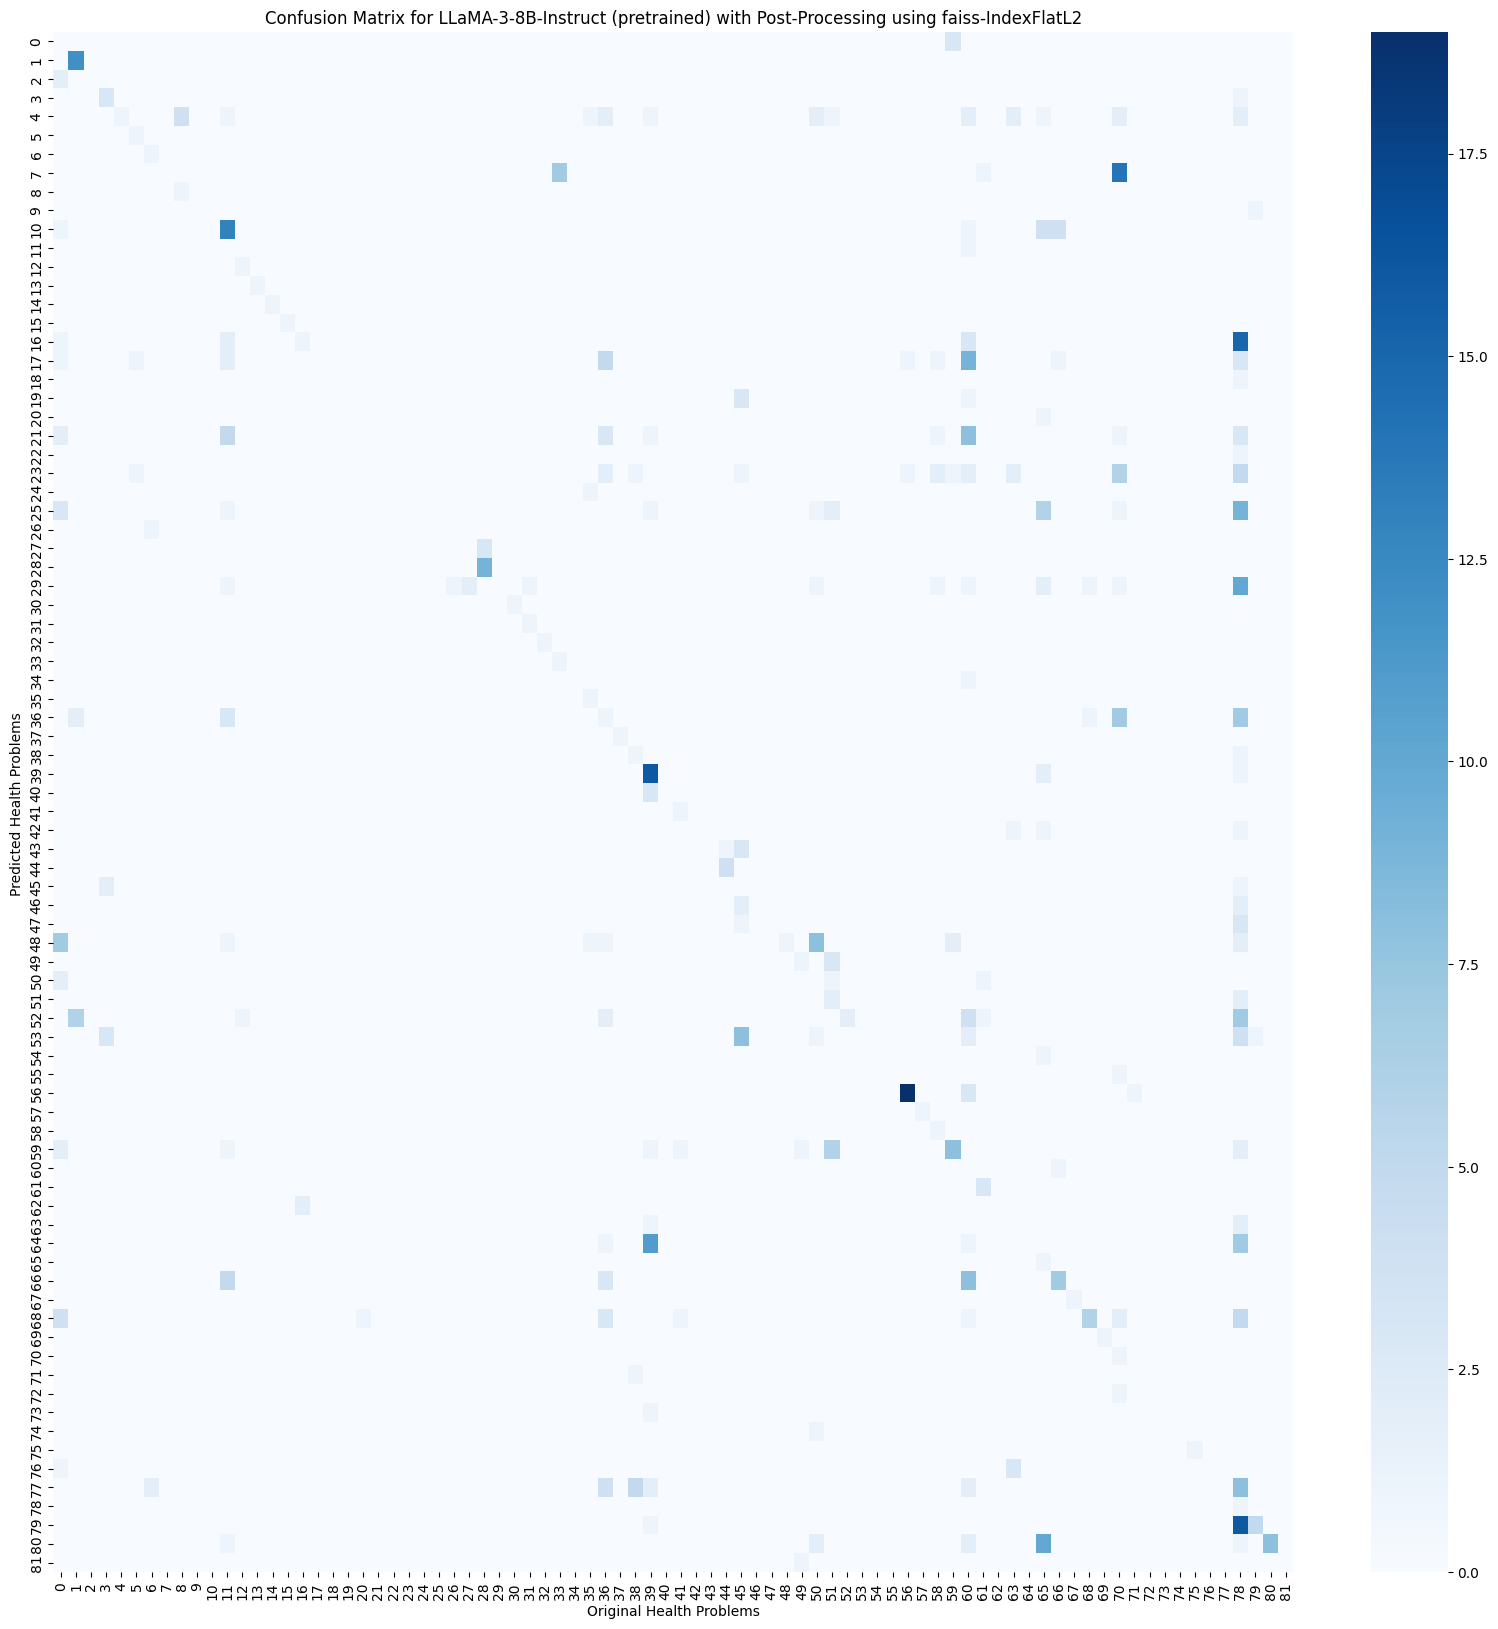

'success'

In [19]:
t2t_evaluate(model_name='LLaMA-3-8B-Instruct',model_type = 'pretrained', csv_file_path='/kaggle/input/dtest-with-predictions-llama-3-8b-instruct-pretra/results/predictions-llama-3-8b-Instruct-pretrained-output.csv')

All elements in predictions are found in original_diseases.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Name :  LLaMA-3-8B-Instruct
Model Type :  fine-tuned

Valid Instruction Following Predictions Score :  1.000

Classification Metrics:

Accuracy: 0.968
Precision: 0.957
Recall: 0.968
F1 Score: 0.961

Text to Text Metrics:

ROUGE Scores:
ROUGE-1: 0.968
ROUGE-2: 0.451
ROUGE-L: 0.969
ROUGE-Lsum: 0.968

Average BERT Precision: 0.994
Average BERT Recall: 0.994
Average BERT F1 Score: 0.994


-------------------------------------------------------------------------------


model-name :  LLaMA-3-8B-Instruct
model-type :  fine-tuned

valid-instruction-rating :  1.000

classification-metrics:

accuracy: 0.968
precision: 0.957
recall: 0.968
f1-score: 0.961

text-to-text-metrics:

rouge-scores:
rouge-1: 0.968
rouge-2: 0.451
rouge-L: 0.969
rouge-lsum: 0.968

bert-precision: 0.994
bert-recall: 0.994
bert-f1-score: 0.994

Updated llms_data dictionary:


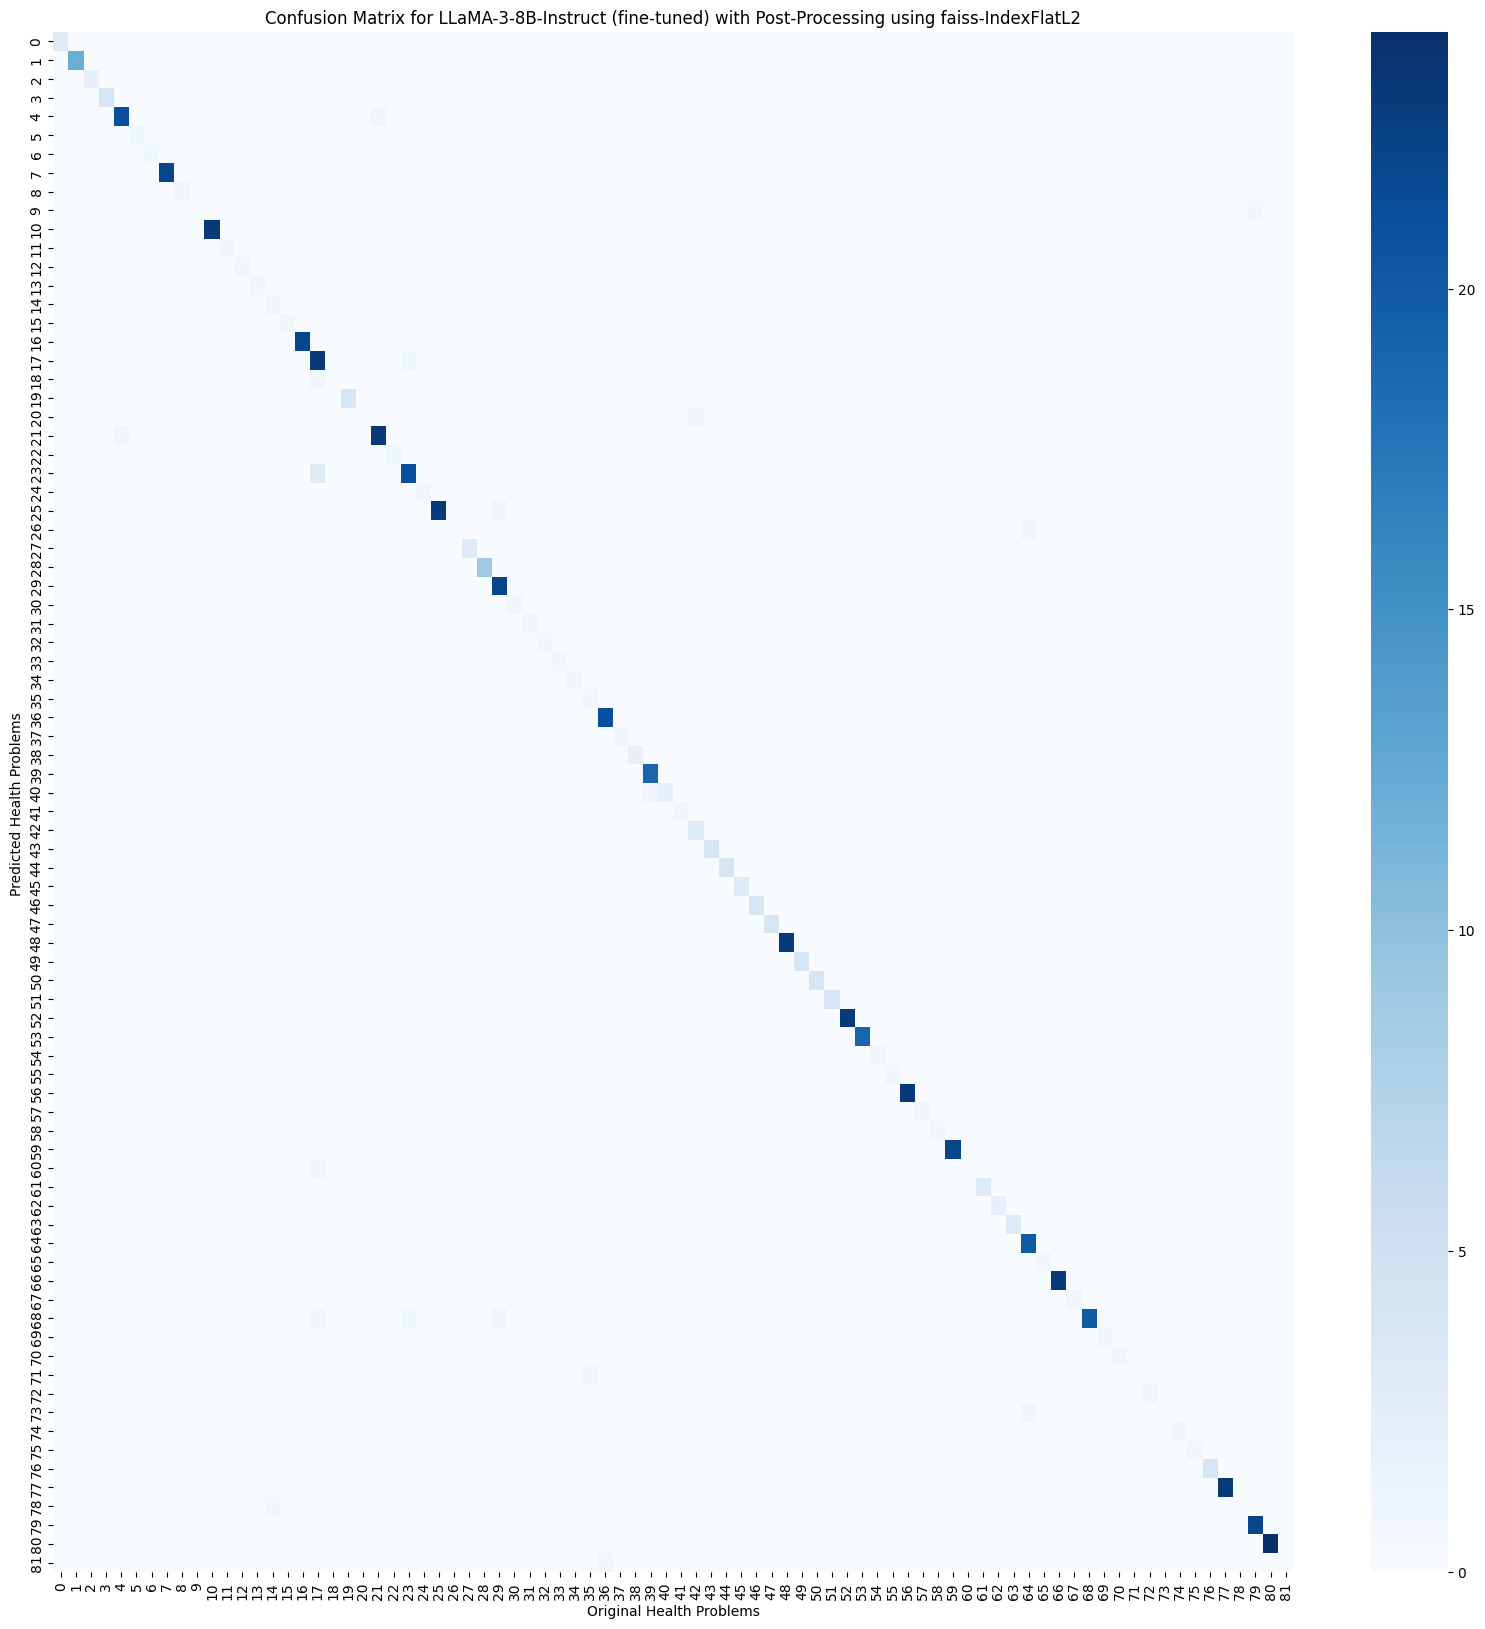

'success'

In [20]:
t2t_evaluate(model_name='LLaMA-3-8B-Instruct',model_type = 'fine-tuned', csv_file_path='/kaggle/input/dtest-with-predictions-llama-3-8b-inst-fine-tuned/results/predictions-llama-3-8b-Instruct-fine-tuned-output.csv')

In [21]:
# llm_model_data = {}

In [22]:
# llm_model_data["qwen2-7b-instruct"]= {
#     "pretrained": {
#         "valid-instruction-rating": 0.997,
#         "classification-metrics": {
#             "accuracy": 0.050,
#             "precision": 0.253,
#             "recall": 0.050,
#             "f1-score": 0.064
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.200,
#                 "rouge-2": 0.073,
#                 "rouge-L": 0.200,
#                 "rouge-lsum": 0.200
#             },
#             "bert-precision": 0.828,
#             "bert-recall": 0.858,
#             "bert-f1-score": 0.842
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.998,
#         "classification-metrics": {
#             "accuracy": 0.738,
#             "precision": 0.931,
#             "recall": 0.738,
#             "f1-score": 0.778
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.871,
#                 "rouge-2": 0.411,
#                 "rouge-L": 0.871,
#                 "rouge-lsum": 0.871
#             },
#             "bert-precision": 0.962,
#             "bert-recall": 0.978,
#             "bert-f1-score": 0.970
#         }
#     }
# }

In [23]:
# llm_model_data["gemma-7b-instruct"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.134,
#         "classification-metrics": {
#             "accuracy": 0.057,
#             "precision": 0.191,
#             "recall": 0.057,
#             "f1-score": 0.074
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.162,
#                 "rouge-2": 0.066,
#                 "rouge-L": 0.162,
#                 "rouge-lsum": 0.162
#             },
#             "bert-precision": 0.838,
#             "bert-recall": 0.842,
#             "bert-f1-score": 0.840
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.974,
#         "classification-metrics": {
#             "accuracy": 0.078,
#             "precision": 0.288,
#             "recall": 0.078,
#             "f1-score": 0.101
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.461,
#                 "rouge-2": 0.201,
#                 "rouge-L": 0.461,
#                 "rouge-lsum": 0.461
#             },
#             "bert-precision": 0.860,
#             "bert-recall": 0.933,
#             "bert-f1-score": 0.895
#         }
#     }
# }


In [24]:
# llm_model_data["mistral-7b-instruct-v0.2"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.982,
#         "classification-metrics": {
#             "accuracy": 0.057,
#             "precision": 0.192,
#             "recall": 0.057,
#             "f1-score": 0.065
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.155,
#                 "rouge-2": 0.064,
#                 "rouge-L": 0.155,
#                 "rouge-lsum": 0.154
#             },
#             "bert-precision": 0.835,
#             "bert-recall": 0.842,
#             "bert-f1-score": 0.838
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.437,
#         "classification-metrics": {
#             "accuracy": 0.383,
#             "precision": 0.482,
#             "recall": 0.383,
#             "f1-score": 0.414
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.715,
#                 "rouge-2": 0.364,
#                 "rouge-L": 0.714,
#                 "rouge-lsum": 0.715
#             },
#             "bert-precision": 0.921,
#             "bert-recall": 0.963,
#             "bert-f1-score": 0.941
#         }
#     }
# }


In [25]:
# llm_model_data["phi-3-medium-4k-instruct"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.416,
#         "classification-metrics": {
#             "accuracy": 0.154,
#             "precision": 0.446,
#             "recall": 0.154,
#             "f1-score": 0.179
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.298,
#                 "rouge-2": 0.079,
#                 "rouge-L": 0.298,
#                 "rouge-lsum": 0.298
#             },
#             "bert-precision": 0.853,
#             "bert-recall": 0.872,
#             "bert-f1-score": 0.862
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.968,
#         "classification-metrics": {
#             "accuracy": 0.015,
#             "precision": 0.081,
#             "recall": 0.015,
#             "f1-score": 0.020
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.482,
#                 "rouge-2": 0.222,
#                 "rouge-L": 0.482,
#                 "rouge-lsum": 0.482
#             },
#             "bert-precision": 0.859,
#             "bert-recall": 0.942,
#             "bert-f1-score": 0.898
#         }
#     }
# }


In [26]:
# llm_model_data["medical-llama3-8b"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.013,
#         "classification-metrics": {
#             "accuracy": 0.139,
#             "precision": 0.354,
#             "recall": 0.139,
#             "f1-score": 0.157
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.174,
#                 "rouge-2": 0.069,
#                 "rouge-L": 0.174,
#                 "rouge-lsum": 0.174
#             },
#             "bert-precision": 0.855,
#             "bert-recall": 0.822,
#             "bert-f1-score": 0.838
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 0.995,
#         "classification-metrics": {
#             "accuracy": 0.057,
#             "precision": 0.204,
#             "recall": 0.057,
#             "f1-score": 0.069
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.488,
#                 "rouge-2": 0.223,
#                 "rouge-L": 0.487,
#                 "rouge-lsum": 0.487
#             },
#             "bert-precision": 0.862,
#             "bert-recall": 0.943,
#             "bert-f1-score": 0.900
#         }
#     }
# }


In [27]:
# llm_model_data["llama-3-8b-instruct"] = {
#     "pretrained": {
#         "valid-instruction-rating": 0.751,
#         "classification-metrics": {
#             "accuracy": 0.107,
#             "precision": 0.237,
#             "recall": 0.107,
#             "f1-score": 0.123
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.238,
#                 "rouge-2": 0.071,
#                 "rouge-L": 0.237,
#                 "rouge-lsum": 0.238
#             },
#             "bert-precision": 0.839,
#             "bert-recall": 0.869,
#             "bert-f1-score": 0.853
#         }
#     },
#     "fine-tuned": {
#         "valid-instruction-rating": 1.000,
#         "classification-metrics": {
#             "accuracy": 0.961,
#             "precision": 0.955,
#             "recall": 0.961,
#             "f1-score": 0.957
#         },
#         "text-to-text-metrics": {
#             "rouge-scores": {
#                 "rouge-1": 0.966,
#                 "rouge-2": 0.448,
#                 "rouge-L": 0.966,
#                 "rouge-lsum": 0.966
#             },
#             "bert-precision": 0.994,
#             "bert-recall": 0.994,
#             "bert-f1-score": 0.994
#         }
#     }
# }


In [28]:
import os
import json

# Define the directory path
directory = f'/kaggle/working/evaluation/{index_type}/results'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, 'medical-chatbot-models-evaluation.json')

# Assuming llms_data contains the dictionary you want to save
with open(file_path, 'w') as json_file:
    json.dump(llms_data, json_file, indent=4)


In [29]:
import csv
import json
import os

directory = f'/kaggle/working/evaluation/{index_type}/results'
file_path = os.path.join(directory, 'medical-chatbot-models-evaluation.csv')

# Create a CSV file and write header
with open(file_path, mode='w', newline='') as file:
    fieldnames = ['model-name', 'type', 'valid-instruction-following', 'accuracy', 'precision', 'recall', 'f1-score', 
                  'rouge-1', 'rouge-2', 'rouge-l', 'rouge-lsum', 'bert-precision', 'bert-recall', 'bert-f1-score']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    
    writer.writeheader()
    
    for model_name, model_types in llms_data.items():
        for model_type, metrics in model_types.items():
            writer.writerow({
                'model-name': model_name,
                'type': model_type,
                'valid-instruction-following': metrics['valid-instruction-rating'],
                'accuracy': metrics['classification-metrics']['accuracy'],
                'precision': metrics['classification-metrics']['precision'],
                'recall': metrics['classification-metrics']['recall'],
                'f1-score': metrics['classification-metrics']['f1-score'],
                'rouge-1': metrics['text-to-text-metrics']['rouge-scores']['rouge-1'],
                'rouge-2': metrics['text-to-text-metrics']['rouge-scores']['rouge-2'],
                'rouge-l': metrics['text-to-text-metrics']['rouge-scores']['rouge-L'],
                'rouge-lsum': metrics['text-to-text-metrics']['rouge-scores']['rouge-lsum'],
                'bert-precision': metrics['text-to-text-metrics']['bert-precision'],
                'bert-recall': metrics['text-to-text-metrics']['bert-recall'],
                'bert-f1-score': metrics['text-to-text-metrics']['bert-f1-score']
            })

print("CSV file created successfully at:", file_path)

CSV file created successfully at: /kaggle/working/evaluation/faiss-IndexFlatL2/results/medical-chatbot-models-evaluation.csv
